In [41]:
# Importing General Libraries
import pandas as pd
import numpy as np

!pip install geopandas 
!pip install cenpy 
!pip install python-graphviz

import geopandas as gpd
import cenpy as cp

# Matplotlib Set-up
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')

# Seaborn Set-Up
import seaborn as sns
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]
matplotlib.style.use('fivethirtyeight')

from scipy import stats
import pymc3 as pm
from pymc3 import glm
import arviz as az
import pickle

ERROR: Could not find a version that satisfies the requirement python-graphviz (from versions: none)
ERROR: No matching distribution found for python-graphviz
/root/venv/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Trump has been described over and over in media as a king-maker, a person who brings leaders to power through the exercise of political influence. The NRA's approval is seen as a necessity in many parts of the country if you wish to win a primary. Biden and Bernie Sanders threw their weight around in 2018 by endorsing primary candidates in an effort to shape this increasingly polarized nightmare of United States politics. The question to ask, however, is how important are these endorsements? Can they predict who go on to win the general election? What can these endorsements tell us about the primary candidates?

# Previewing Datasets

The purpose of this notebook is to show the first bit of data for each dataset we will be using in our analysis. Similar to a README file. The datasets we currently have include democrat candidates, republican candidates, and financial endorsements.

### Democrats

The `dem` dataset contains the election results and endorsements for each candidate. Among the democrats endorsement may come from Biden, Warren, Sanders, Justice Dems, PCCC, WFP, VoteVets, and more. One key difference between this dataset and that of the republicans is that they provide information on the candidates background (race, etc.)

In [5]:
dem = pd.read_csv("data/dem_candidates.csv")
print(dem.shape)
dem.head(2)

(811, 32)


Candidate State             District Office Type Race Type  \
0  Anthony White (Alabama)    AL  Governor of Alabama    Governor   Regular   
1   Christopher Countryman    AL  Governor of Alabama    Governor   Regular   

  Race Primary Election Date Primary Status Primary Runoff Status  \
0                     6/5/18           Lost                  None   
1                     6/5/18           Lost                  None   

  General Status  Partisan Lean  ...  Biden Endorsed? Warren Endorsed?   \
0           None     -28.879999  ...              NaN               NaN   
1           None     -28.879999  ...              NaN               NaN   

  Sanders Endorsed? Our Revolution Endorsed? Justice Dems Endorsed?  \
0               NaN                      NaN                    NaN   
1               NaN                      NaN                    NaN   

  PCCC Endorsed? Indivisible Endorsed? WFP Endorsed? VoteVets Endorsed?  \
0            NaN                   NaN           NaN                NaN   
1            NaN                   NaN           NaN                NaN   

  No Labels Support?  
0                NaN  
1                NaN  

[2 rows x 32 columns]

### Republicans

The `rep` dataset contains the election results and endorsements for each candidate. Among the republican candidates endorsement may come from Trump, Bannon, Great America, NRA, Right to Life, and more

In [7]:
rep = pd.read_csv("data/rep_candidates.csv",encoding='latin-1')
print(rep.shape)
rep.head(2)

(774, 25)


Candidate State            District Office Type Race Type  \
0    Mike Dunleavy    AK  Governor of Alaska    Governor   Regular   
1  Michael Sheldon    AK  Governor of Alaska    Governor   Regular   

  Race Primary Election Date Primary Status Primary Runoff Status  \
0                    8/21/18       Advanced                  None   
1                    8/21/18           Lost                  None   

  General Status  Primary %  ... NRA Endorsed? Right to Life Endorsed?  \
0  On the Ballot       61.8  ...           NaN                     NaN   
1           None        2.2  ...           NaN                     NaN   

  Susan B. Anthony Endorsed? Club for Growth Endorsed? Koch Support?  \
0                        NaN                       NaN           NaN   
1                        NaN                       NaN           NaN   

  House Freedom Support? Tea Party Endorsed? Main Street Endorsed?  \
0                    NaN                 NaN                   NaN   
1                    NaN                 NaN                   NaN   

  Chamber Endorsed? No Labels Support?  
0               NaN                NaN  
1               NaN                NaN  

[2 rows x 25 columns]

# Combining Candidates Data
If we wanted to compare candidates between parties, we could combine the two datasets. However, it is important to note that the endorsement columns are not similar between the candidates of different parties. I removed those columns to combine the two datasets.


In [13]:
# Adding a column to reference the candidates Party
dem['Party'] = 'democrat'
rep['Party'] = 'republican'

# Columns contained in both datasets
common_cols = [i for i in dem.columns if i in rep.columns]

# Filtering both tables for those columns
short_dem = dem[common_cols]
short_rep = rep[common_cols]

# Appending those tables to create 1 large dataset
candidates = short_dem.append(short_rep).reset_index(drop=True)
candidates.head(2)

Candidate State             District Office Type Race Type  \
0  Anthony White (Alabama)    AL  Governor of Alabama    Governor   Regular   
1   Christopher Countryman    AL  Governor of Alabama    Governor   Regular   

  Race Primary Election Date Primary Status Primary Runoff Status  \
0                     6/5/18           Lost                  None   
1                     6/5/18           Lost                  None   

  General Status  Primary % Won Primary No Labels Support?     Party  
0           None       3.42          No                NaN  democrat  
1           None       1.74          No                NaN  democrat

# Visualizing Winning vs Primary %

Here, we can see the relationship between winning an election and percent of vote received in the primary

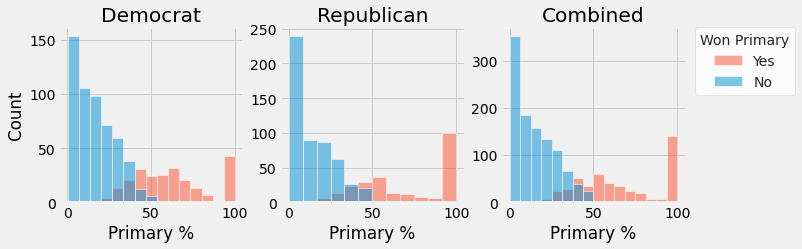

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10,3), ncols=3, nrows=1)
order = ["No", "Yes"]
sns.set_style("white")
sns.histplot(data=dem, x="Primary %", hue="Won Primary", hue_order=order, ax=ax1)
ax1.set(title="Democrat")
ax1.legend_.remove()
sns.histplot(data=rep, x="Primary %", hue="Won Primary", hue_order=order, ax=ax2)
ax2.set(title="Republican", ylabel=None)
ax2.legend_.remove()
sns.histplot(data=candidates, x="Primary %", hue="Won Primary", hue_order=order, ax=ax3)
ax3.set(title="Combined", ylabel=None)
#fig.legend('ABCDEF',bbox_to_anchor=(.99, 1), ncol=2, loc='right');
ax3.set(title="Combined", ylabel=None)
ax3.legend(labels=['Yes','No'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Won Primary")
plt.show()


In [16]:
dem[['Won Primary', 'Primary %']].groupby('Won Primary').agg(max)

Primary %
Won Primary            
No            49.610001
Yes          100.000000

In [17]:
rep[['Won Primary', 'Primary %']].groupby('Won Primary').agg(max)

Primary %
Won Primary           
No               100.0
Yes              100.0

# Democratic Box Plots

Here, we take a look at the distribution of primary percents by endorsement.

In [20]:
def get_endorser(column_name):
    '''
    Changes the column name from things like "Biden Endorsed?"
    to "Biden" or "Justice Dems Endorsed?" to "Justice Dems"
    '''
    assert column_name
    return " ".join(column_name.split()[0:-1])
dem_endorsements = pd.DataFrame(columns=list(dem.columns)+["Endorsement"])
for endorsement in dem.columns[dem.columns.str.contains("Endorsed?")]:
    tmp_df = dem[dem[endorsement]=="Yes"]
    tmp_df["Endorsement"] = " ".join(endorsement.split()[0:-1])
    dem_endorsements = dem_endorsements.append(tmp_df)

rep_endorsements = pd.DataFrame(columns=list(rep.columns)+["Endorsement"])
for endorsement in rep.columns[rep.columns.str.contains("Endorsed?")]:
    tmp_df = rep[rep[endorsement]=="Yes"]
    tmp_df["Endorsement"] = " ".join(endorsement.split()[0:-1])
    rep_endorsements = rep_endorsements.append(tmp_df)
dem_endorsements.groupby("Endorsement").mean()["Primary %"].sort_values(ascending=False)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Endorsement
Biden             76.027002
Warren            54.098000
Indivisible       52.063721
Sanders           50.327778
Emily             50.259020
PCCC              48.311334
VoteVets          46.786786
WFP               44.509333
Justice Dems      35.264082
Our Revolution    33.716988
Name: Primary %, dtype: float64

In [22]:
rep_endorsements.groupby("Endorsement").mean()["Primary %"].sort_values(ascending=False)

Endorsement
Trump               58.274706
Club for Growth     52.317619
Chamber             51.877500
NRA                 50.507857
Great America       49.614286
Bannon              46.406250
Tea Party           41.061250
Susan B. Anthony    41.053478
Right to Life       37.178378
Main Street         35.574706
Name: Primary %, dtype: float64

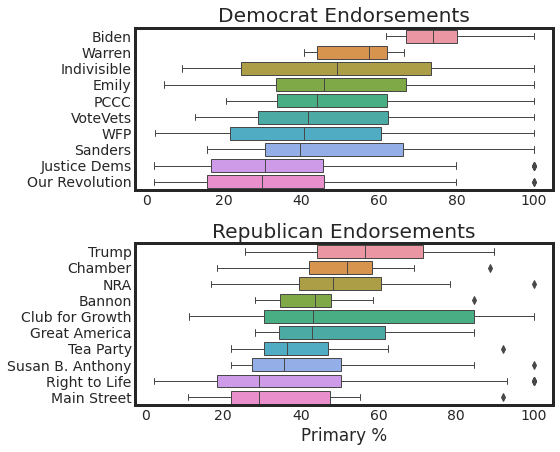

In [23]:
dims = (8, 6.5)
sns.set_style("white")
fig, (ax1, ax2) = plt.subplots(figsize=dims, nrows=2, ncols=1)
linewidth=1
order = dem_endorsements.groupby("Endorsement").median()["Primary %"].sort_values(ascending=False).index
sns.boxplot(data=dem_endorsements, y="Endorsement", x="Primary %", ax=ax1, order=order, linewidth=linewidth)
ax1.title.set_text("Democrat Endorsements");
ax1.set(xlabel=None,ylabel=None)
order = rep_endorsements.groupby("Endorsement").median()["Primary %"].sort_values(ascending=False).index
sns.boxplot(data=rep_endorsements, y="Endorsement", x="Primary %", ax=ax2, order=order, linewidth=linewidth)
ax2.title.set_text("Republican Endorsements");
ax2.set(ylabel=None)
plt.tight_layout()

## Misleading Plots

From these plots, it may seem that Trump and (especially) Biden are indeed the kingmakers here! The people they endorsed generally got elected. When looking at the actual counts of endorsements, we can see that Trump gave 17 endorsements, Biden gave a total of 10 endorsements, and Warren gave 5 (which makes that 5 point summary above represent literally all the datapoints exactly). That makes these comparisons to organizations like Our Revolution (with 85 endorsements) and Right to Life (with 74 endorsements) invalid.

There are a few possibilities here. These choosey candidates may truly have immense sway over the election or they just may be picking poeple that are already going to win without their help. It's impossible to tease out the difference, but perhaps we can perform a few tests to see if these endorsements make give us some insight about who will win in the primary.

In [24]:
pd.DataFrame.from_dict(
    dict(rep_endorsements.groupby("Endorsement").count()["Candidate"].sort_values(ascending=False)),
    orient="index").rename(columns={0:"Endorsements"})

Endorsements
Right to Life               74
Susan B. Anthony            23
Club for Growth             21
Main Street                 17
Trump                       17
Tea Party                   16
NRA                         14
Bannon                       8
Chamber                      8
Great America                7

# Bonferroni & Benjamini Hochberg Correction p-tests

Null hypothesis is that endorsements have the same distribution as people without endorsements

Bootstrap the labels on who endorsed who. Find the distribution on the mean percentage. See where in the distribution real observed values fall in these cases.

In [27]:
def permutation_test(column, df, ax=0, n=5000):
    '''
    Performs a bootstrapped permutation test with n samples.
    Calculates the percentage of primary wins 
    by candidates who were endorsed by a specific group/person.
    Plots a histogram in the variance in that statistic with a verticle
    line for the observed results.

    input:
        column (str) : The name of the column to perform the permutation test on (The person endorsing)
        df (str) : The dataframe to bootstrap from
        n (int) : Number of samples to take in the bootstrap

    output:
        results (array[float]) : The results of percentage of wins from the n samples.
    '''

    if not ax:
        ax = plt.subplot()

    results = np.zeros(n)
    for i in range(n):
        df_copy = df[[column, "Won Primary"]].copy()
        df_copy.loc[:,"resample"] = df[column].sample(frac=1, replace=False).to_numpy()
        results_yes = df_copy[df_copy["resample"] == "Yes"]
        results[i] = (results_yes[results_yes["Won Primary"] == "Yes"].shape[0]
                        /results_yes["Won Primary"].count())
    sns.histplot(results, stat="density", ax=ax, bins=np.linspace(0,1,25))
    df_column = df[df[column]=="Yes"]
    obs_mean = df_column[df_column["Won Primary"] == "Yes"].shape[0]/df_column["Won Primary"].count()
    plt.axvline(x=obs_mean, color="orange", lw=2)
    plt.subplots_adjust(hspace=0.4)
    plt.title(column, fontsize=14)
    plt.xlabel("Win Rate", fontsize=14)
    # Creating cutoff
    plt.axvline(x=np.quantile(results, .95), color="red", linestyle="dashed", linewidth=1)
    pval = sum(results >= obs_mean)/n
    return pval

In [28]:
dem_endorsers = dem.columns[dem.columns.str.contains("Endorsed")]
dem_endorsers

Index(['Emily Endorsed?', 'Biden Endorsed?', 'Warren Endorsed? ',
       'Sanders Endorsed?', 'Our Revolution Endorsed?',
       'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?',
       'WFP Endorsed?', 'VoteVets Endorsed?'],
      dtype='object')

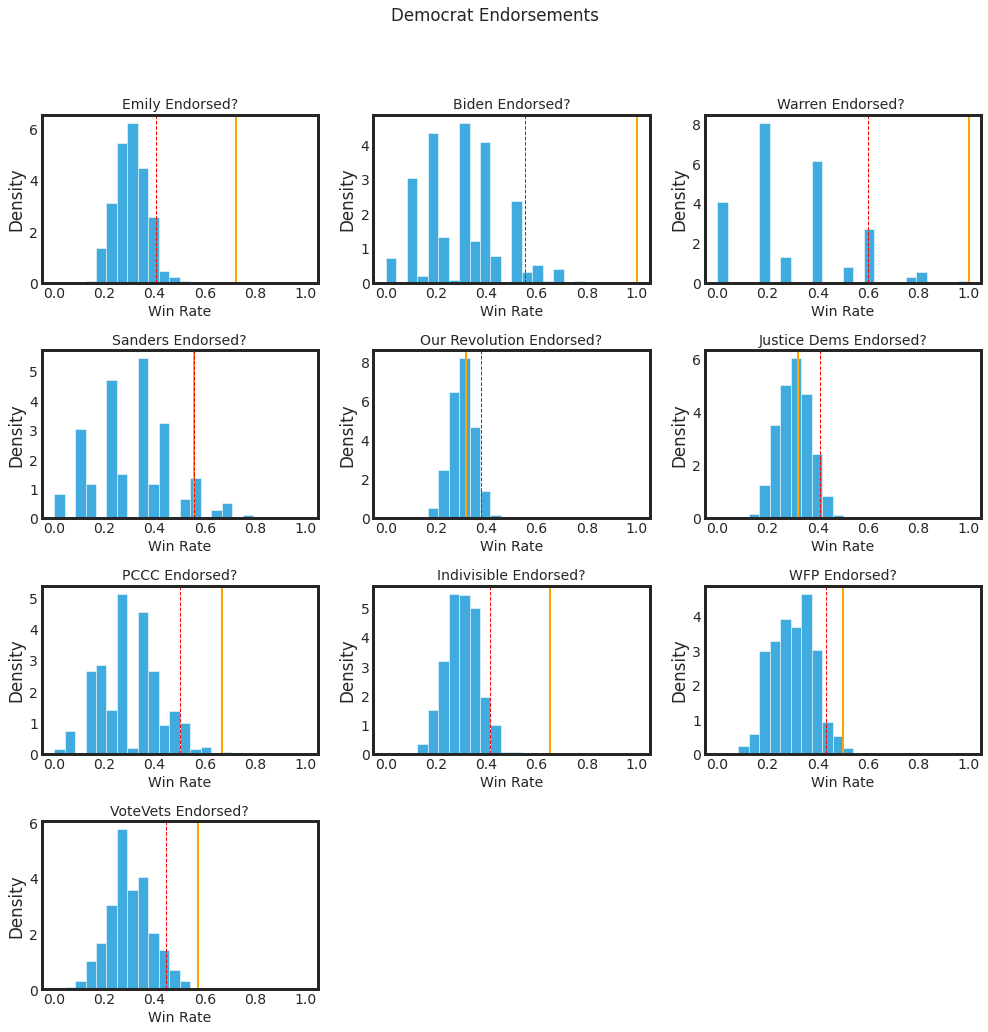

In [32]:
fig = plt.figure(figsize=[15,15])
p_vals_dem = {}
for i in np.arange(10):
    ax = plt.subplot(4,3, i+1)
    p_vals_dem[get_endorser(dem_endorsers[i])] = permutation_test(dem_endorsers[i], dem, ax=ax, n=1000)

fig.suptitle("Democrat Endorsements");

In [33]:
dem_endorsers = dem.columns[dem.columns.str.contains("Endorsed")]
dem_endorsers

Index(['Emily Endorsed?', 'Biden Endorsed?', 'Warren Endorsed? ',
       'Sanders Endorsed?', 'Our Revolution Endorsed?',
       'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?',
       'WFP Endorsed?', 'VoteVets Endorsed?'],
      dtype='object')

AttributeError: 'Figure' object has no attribute 'update_layout'

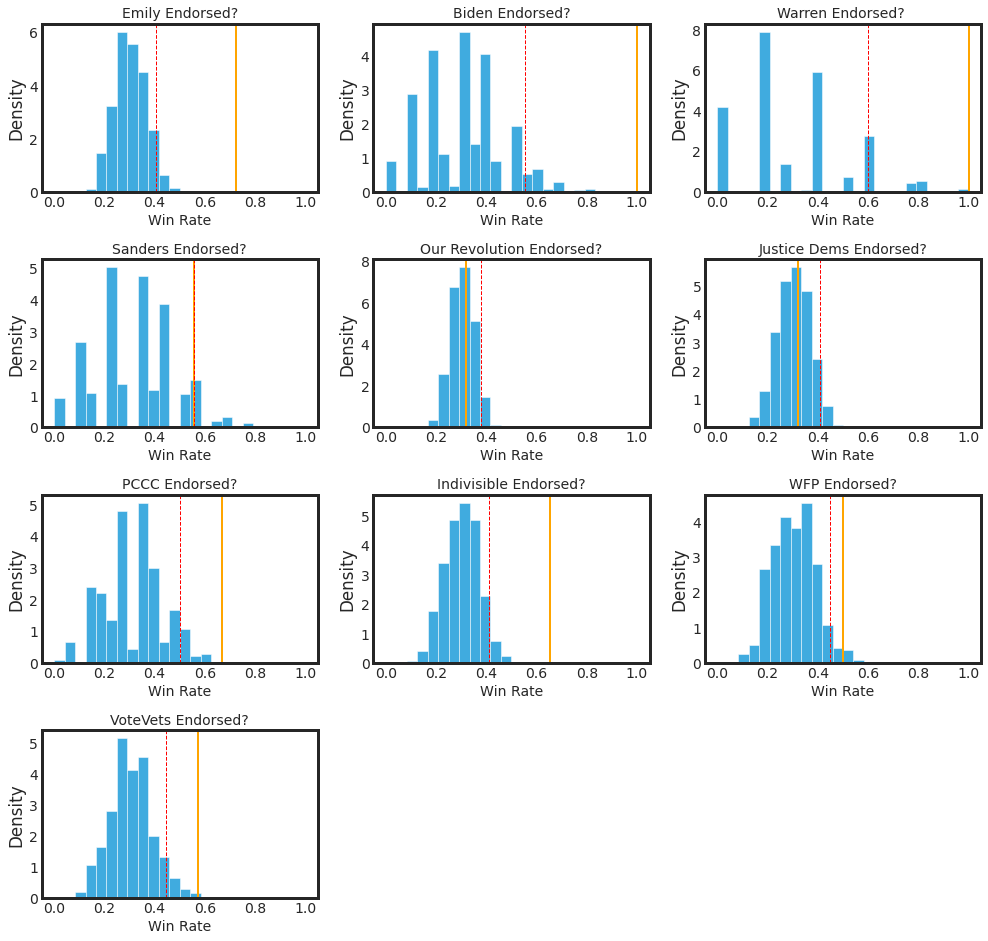

In [34]:
fig = plt.figure(figsize=[15,15])
p_vals_dem = {}
for i in np.arange(10):
    ax = plt.subplot(4,3, i+1)
    p_vals_dem[get_endorser(dem_endorsers[i])] = permutation_test(dem_endorsers[i], dem, ax=ax, n=1000)
fig.update_layout( paper_bgcolor= 'rgba(0, 0, 0, 0)')

fig.suptitle("Democrat Endorsements");

In [ ]:
def bonferroni_bh_plot(p_vals, max_y=0):
    """ 
    Calculates and sorts the p-values for each test, then plotting them against 
    the Bonferroni and Benjamini Hochberg p-value cutoff corrections. Then, plots 
    the Bonferroni and BH cutoffs againsts the p-values in a barplot.

    inputs:
        p_vals (dict): dictionary with endorser keys and the p-value for 
                        each endorsement
        max_y (float): maximum value for the y axis on the plot

    outputs:
        df_pvals (df): table with columns for the endorser, p-value, whether they 
                    are below the Bonferroni cutoff, and whether they are below the
                    BH cutoff.
    """

    alpha = 0.95
    bonferroni_correction = (1-alpha)/len(p_vals)
    df_pvals = (pd.DataFrame.from_dict(p_vals, orient="index"))
    df_pvals.index.rename("Endorsement", inplace=True)
    df_pvals.rename(columns={0:"P-Value"}, inplace=True)
    df_pvals.sort_values("P-Value", inplace=True)
    df_pvals.reset_index(inplace=True)

    df_pvals['Below Bonferroni Cutoff'] = df_pvals['P-Value'] <= bonferroni_correction


    p = sns.barplot(x="Endorsement", y="P-Value", data=df_pvals)
    p.set_xticklabels(p.get_xticklabels(), rotation=90)
    plt.axhline(y=bonferroni_correction, label="Bonferroni Cutoff", lw=1.5, color="red", ls="dashed")
    #plt.yscale('log')
    x = np.arange(0-1,len(p_vals)+2)
    y = bonferroni_correction * (x+1)
    
    df_pvals['Below BH Cutoff'] = df_pvals['P-Value'] <= y[1:len(p_vals)+1]
    plt.xlim(-0.5,len(p_vals))
    if not max_y:
        plt.ylim(0,max(df_pvals["P-Value"]))
    else:
        plt.ylim(0,max_y)
    plt.plot(x, y, color="purple", label="BH Cutoff", lw=1.5, ls="dashed")
    p.legend()

    return df_pvals

bonferroni_bh_plot(p_vals_dem)


In [ ]:
# Republicans Endorsements

In [30]:
rep_endorsers = rep.columns[rep.columns.str.contains("Endorsed")]
rep_endorsers

Index(['Trump Endorsed?', 'Bannon Endorsed?', 'Great America Endorsed?',
       'NRA Endorsed?', 'Right to Life Endorsed?',
       'Susan B. Anthony Endorsed?', 'Club for Growth Endorsed?',
       'Tea Party Endorsed?', 'Main Street Endorsed?', 'Chamber Endorsed?'],
      dtype='object')

In [ ]:
fig = plt.figure(figsize=[15,15])
p_vals_rep = {}
for i in np.arange(10):
    ax = plt.subplot(4,3, i+1)
    p_vals_rep[get_endorser(rep_endorsers[i])] = permutation_test(rep_endorsers[i], rep, ax=ax, n=1000)
fig.suptitle("Republican Endorsements")

In [ ]:
bonferroni_bh_plot(p_vals_rep)

In [ ]:
fig = plt.figure(figsize=[15,6])
p_vals_lst = [p_vals_dem, p_vals_rep]
test_titles = ["Democrat", "Republican"]
p_vals_max = max(max(p_vals_dem.values()), max(p_vals_rep.values()))
for i in np.arange(2):
    ax = plt.subplot(1,2,i+1)    
    bonferroni_bh_plot(p_vals_lst[i], max_y=p_vals_max)
    plt.title(test_titles[i])

fig.suptitle('P-Values, Bonferroni Cutoffs, and Benjamini Hochberg Cutoffs');

## Bring in list of all candidates and races

In [35]:
endorsements = pd.read_csv('data/endorsements_joined.csv', usecols=['State', 'District', 'Office Type'])
endorsements

State             District Office Type
0       AL  Governor of Alabama    Governor
1       AL  Governor of Alabama    Governor
2       AL  Governor of Alabama    Governor
3       AL  Governor of Alabama    Governor
4       AL  Governor of Alabama    Governor
...    ...                  ...         ...
1615    WY  Governor of Wyoming    Governor
1616    WY  Governor of Wyoming    Governor
1617    WY  Governor of Wyoming    Governor
1618    WY  Governor of Wyoming    Governor
1619    WY  Governor of Wyoming    Governor

[1620 rows x 3 columns]

### Narrow down to unique races by state and district

In [37]:
unique_races = endorsements.groupby(['State', 'District'], as_index=False).first()
unique_races

State                             District     Office Type
0      AK                   Governor of Alaska        Governor
1      AL                  Governor of Alabama        Governor
2      AL        U.S. House Alabama District 1  Representative
3      AL        U.S. House Alabama District 2  Representative
4      AL        U.S. House Alabama District 3  Representative
..    ...                                  ...             ...
421    WV  U.S. House West Virginia District 1  Representative
422    WV  U.S. House West Virginia District 2  Representative
423    WV  U.S. House West Virginia District 3  Representative
424    WV            U.S. Senate West Virginia         Senator
425    WY                  Governor of Wyoming        Governor

[426 rows x 3 columns]

## We will need to do some string manipulation to get join-able columns

Let's break the data down into two different subsets based on whether the race is for Senator/Governor (state level) or Representative (district level).

In [39]:
state_races = unique_races[(unique_races['Office Type'] == 'Senator') | (unique_races['Office Type'] == 'Governor')]
state_races
district_races = unique_races[unique_races['Office Type'] == 'Representative']
district_races['District'] = district_races['District'].str.extract('(\d{1,2}|At-large)')
district_races.loc[district_races['District'] == 'At-large', 'District'] = 0
district_races['District'] = district_races['District'].astype('int64')
district_races

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

State  District     Office Type
2      AL         1  Representative
3      AL         2  Representative
4      AL         3  Representative
5      AL         4  Representative
6      AL         5  Representative
..    ...       ...             ...
418    WI         3  Representative
419    WI         4  Representative
421    WV         1  Representative
422    WV         2  Representative
423    WV         3  Representative

[363 rows x 3 columns]

Now we can join these two DataFrames on state abbreviation and/or district number.

## Bring in census data on states and districts

Hat tip to cenpy documentation [here](https://nbviewer.jupyter.org/github/ljwolf/cenpy/blob/master/notebooks/automatic-wrapper.ipynb?flush_cache=true).

In [42]:

# find the name of the census product we want
t = cp.explorer.available()
t = t[t['description'].str.contains('ACS')]
t = t[t['title'].str.contains('American Community Survey: 1-Year Estimates: Detailed Tables 1-Year')]
t = t[t['vintage'] == 2018]
t.index[0]

'ACSDT1Y2018'

In [43]:
product = 'ACSDT1Y2018'
connection = cp.remote.APIConnection(product)
display(connection.variables)

label  \
for                                Census API FIPS 'for' clause   
in                                  Census API FIPS 'in' clause   
ucgid                Uniform Census Geography Identifier clause   
B24022_060E   Estimate!!Total!!Female!!Service occupations!!...   
B19001B_014E              Estimate!!Total!!$100,000 to $124,999   
...                                                         ...   
B20005I_071E  Estimate!!Total!!Female!!Worked full-time, yea...   
B25124_022E   Estimate!!Total!!Owner occupied!!3-person hous...   
B08113_054E   Estimate!!Total!!Worked at home!!Speak other l...   
B06009_006E    Estimate!!Total!!Graduate or professional degree   
B05009_012E   Estimate!!Total!!Under 6 years!!Living with tw...   

                                                        concept predicateType  \
for                          Census API Geography Specification      fips-for   
in                           Census API Geography Specification       fips-in   
ucgid                        Census API Geography Specification         ucgid   
B24022_060E   SEX BY OCCUPATION AND MEDIAN EARNINGS IN THE P...           int   
B19001B_014E  HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 201...           int   
...                                                         ...           ...   
B20005I_071E  SEX BY WORK EXPERIENCE IN THE PAST 12 MONTHS B...           int   
B25124_022E      TENURE BY HOUSEHOLD SIZE BY UNITS IN STRUCTURE           int   
B08113_054E   MEANS OF TRANSPORTATION TO WORK BY LANGUAGE SP...           int   
B06009_006E   PLACE OF BIRTH BY EDUCATIONAL ATTAINMENT IN TH...           int   
B05009_012E   AGE AND NATIVITY OF OWN CHILDREN UNDER 18 YEAR...           int   

                group limit predicateOnly  \
for               N/A     0          True   
in                N/A     0          True   
ucgid             N/A     0          True   
B24022_060E    B24022     0           NaN   
B19001B_014E  B19001B     0           NaN   
...               ...   ...           ...   
B20005I_071E  B20005I     0           NaN   
B25124_022E    B25124     0           NaN   
B08113_054E    B08113     0           NaN   
B06009_006E    B06009     0           NaN   
B05009_012E    B05009     0           NaN   

                                            attributes required  
for                                                NaN      NaN  
in                                                 NaN      NaN  
ucgid                                              NaN      NaN  
B24022_060E      B24022_060M,B24022_060MA,B24022_060EA      NaN  
B19001B_014E  B19001B_014EA,B19001B_014M,B19001B_014MA      NaN  
...                                                ...      ...  
B20005I_071E  B20005I_071M,B20005I_071MA,B20005I_071EA      NaN  
B25124_022E      B25124_022M,B25124_022MA,B25124_022EA      NaN  
B08113_054E      B08113_054EA,B08113_054M,B08113_054MA      NaN  
B06009_006E      B06009_006EA,B06009_006M,B06009_006MA      NaN  
B05009_012E      B05009_012EA,B05009_012M,B05009_012MA      NaN  

[35529 rows x 8 columns]

## Holy variables, Batman! 

The data dictionary is [here](https://api.census.gov/data/2018/acs/acs1/variables.html). There are over 35,000 variables available!

In [44]:
acs_vars = {'B01003_001E':'Total_Population', 'B02001_002E':'Race_White', 
            'B02001_003E':'Race_Black', 'B02001_004E':'Race_AmerInd', 
            'B02001_005E':'Race_Asian', 'B02001_006E':'Race_PacIsl', 
            'B02001_007E':'Race_Other', 'B02001_008E':'Race_TwoOrMore', 
            'B19025_001E':'Agg_Household_Income', 'B01001_007E':'Age_18_19_M',
            'B01001_008E':'Age_20_M', 'B01001_009E':'Age_21_M', 'B01001_010E':'Age_22_24_M',
            'B01001_011E':'Age_25_29_M', 'B01001_012E':'Age_30_34_M', 'B01001_013E':'Age_35_39_M',
            'B01001_014E':'Age_40_44_M', 'B01001_015E':'Age_45_49_M', 'B01001_016E':'Age_50_54_M',
            'B01001_017E':'Age_55_59_M', 'B01001_018E':'Age_60_61_M', 'B01001_019E':'Age_62_64_M',
            'B01001_020E':'Age_65_66_M', 'B01001_021E':'Age_67_69_M', 'B01001_022E':'Age_70_74_M',
            'B01001_023E':'Age_75_79_M', 'B01001_024E':'Age_80_84_M', 'B01001_025E':'Age_85_over_M',
            'B01001_031E':'Age_18_19_F',
            'B01001_032E':'Age_20_F', 'B01001_033E':'Age_21_F', 'B01001_034E':'Age_22_24_F',
            'B01001_035E':'Age_25_29_F', 'B01001_036E':'Age_30_34_F', 'B01001_037E':'Age_35_39_F',
            'B01001_038E':'Age_40_44_F', 'B01001_039E':'Age_45_49_F', 'B01001_040E':'Age_50_54_F',
            'B01001_041E':'Age_55_59_F', 'B01001_042E':'Age_60_61_F', 'B01001_043E':'Age_62_64_F',
            'B01001_044E':'Age_65_66_F', 'B01001_045E':'Age_67_69_F', 'B01001_046E':'Age_70_74_F',
            'B01001_047E':'Age_75_79_F', 'B01001_048E':'Age_80_84_F', 'B01001_049E':'Age_85_over_F',
            'B17002_002E':'Inc_Pov_Ratio_below_50', 'B17002_003E':'Inc_Pov_Ratio_50_74', 
            'B17002_004E':'Inc_Pov_Ratio_75_99', 'B17002_005E':'Inc_Pov_Ratio_100_124',
            'B17002_006E':'Inc_Pov_Ratio_125_149', 'B17002_007E':'Inc_Pov_Ratio_150_174',
            'B17002_008E':'Inc_Pov_Ratio_175_184', 'B17002_009E':'Inc_Pov_Ratio_185_199',
            'B17002_010E':'Inc_Pov_Ratio_200_299', 'B17002_011E':'Inc_Pov_Ratio_300_399',
            'B17002_012E':'Inc_Pov_Ratio_400_499', 'B17002_013E':'Inc_Pov_Ratio_above_500'}

# query 2018 ACS for data on all congressional districts
acs_data_by_district = connection.query(list(acs_vars.keys()), geo_unit='congressional district')
acs_data_by_district = acs_data_by_district.rename(acs_vars, axis=1).fillna(0)
acs_data_by_district = acs_data_by_district.astype('int64')
acs_data_by_district

Total_Population  Race_White  Race_Black  Race_AmerInd  Race_Asian  \
0              715346      479949      196891          6992       10627   
1              678122      426674      217977          2838        7442   
2              708409      490987      183949          1300       13049   
3              686297      591084       51171          4391        3072   
4              725634      539903      130913          3123       12215   
..                ...         ...         ...           ...         ...   
432            714886      660186       15080          3448       17053   
433            710420      660634        5661         13419       12134   
434            735997      662077       12052         19016       15780   
435            577737      528453        3667         16185        5807   
436           3195153     2079304      400936          4013        5144   

     Race_PacIsl  Race_Other  Race_TwoOrMore  Agg_Household_Income  \
0            183        7691           13013           17907552200   
1             26        8158           15007           16457270400   
2              0        6291           12833           17050958700   
3            677       20337           15565           16330810400   
4            160       19959           19361           22597094400   
..           ...         ...             ...                   ...   
432          123        5516           13480           23073914000   
433          538        4104           13930           22483625700   
434          276        9835           16961           23683470900   
435         1111        8798           13716           18865727100   
436          767      551773          153216           37799808200   

     Age_18_19_M  ...  Inc_Pov_Ratio_75_99  Inc_Pov_Ratio_100_124  \
0           8513  ...                28731                  36211   
1           9041  ...                35744                  34868   
2          12638  ...                30859                  33677   
3           9658  ...                38429                  36420   
4           9192  ...                29209                  34528   
..           ...  ...                  ...                    ...   
432         8925  ...                19488                  25912   
433         6962  ...                26179                  29452   
434         9163  ...                23428                  25740   
435         9941  ...                18969                  19991   
436        46416  ...               306145                 285104   

     Inc_Pov_Ratio_125_149  Inc_Pov_Ratio_150_174  Inc_Pov_Ratio_175_184  \
0                    40247                  34270                  12779   
1                    36776                  35154                   9103   
2                    35588                  45481                  14247   
3                    38686                  33432                  18126   
4                    29506                  31400                  13614   
..                     ...                    ...                    ...   
432                  22101                  25299                  12964   
433                  27933                  30940                  13653   
434                  25297                  36898                  11080   
435                  20323                  24256                  11214   
436                 245369                 207159                  79211   

     Inc_Pov_Ratio_185_199  Inc_Pov_Ratio_200_299  Inc_Pov_Ratio_300_399  \
0                    16615                 133013                  92613   
1                    14959                 115007                  96657   
2                    21433                 108335                 101342   
3                    19455                 127655                  95292   
4                    17714                 110211                  97493   
..                     ...                    ...                

### Query 2018 ACS for data on all states

In [46]:

acs_data_by_state = connection.query(list(acs_vars.keys()), geo_unit='state')
acs_data_by_state = acs_data_by_state.rename(acs_vars, axis=1).fillna(0)
acs_data_by_state = acs_data_by_state.astype('int64')
acs_data_by_state

Total_Population  Race_White  Race_Black  Race_AmerInd  Race_Asian  \
0            5695564     4790677      237578         55146      180277   
1            6691878     5539927      637277         14040      154220   
2            4468402     3875023      354761          8470       65300   
3            4659978     2877115     1509407         25657       76255   
4           12741080     9135145     1793079         35846      717938   
5            3156145     2846099      115137         11494       79971   
6            1356458     1253931       23432          3562       36048   
7            3013825     2306096      456714         20951       47548   
8             967171      659781      217594          4397       39023   
9            5611179     4629375      367653         60983      273126   
10           1062305      941438        5056         68013        8517   
11           1338404     1261453       18954          8566       15683   
12          10383620     7098569     2222533        120845      306682   
13          10519475     6127645     3319691         34485      436051   
14            737438      474555       25197        111371       46381   
15           4887871     3306838     1307040         22063       65095   
16            626299      589337        7621          1743       11859   
17           3034392     1924976      280385         44666      250137   
18           1805832     1679773       68679          2629       13459   
19           3943079     2845906      287680        307183       84694   
20           5813568     4957243      370632         50364      165380   
21           3195153     2079304      400936          4013        5144   
22           8517685     5737580     1631512         22265      555422   
23            760077      651687       25896         41270       13749   
24           5084127     3407706     1353599         23672       80969   
25           4190713     3514983       82046         49051      190680   
26            577737      528453        3667         16185        5807   
27          39557045    23535388     2283850        302792     5821585   
28           2986530     1735455     1135599         13234       26142   
29           3572665     2688136      391552          9507      165855   
30          28701845    21099066     3527027        149997     1430857   
31           6042718     3305047     1810885         13433      378985   
32          21299325    15899574     3410741         59870      593634   
33           6902149     5335175      537523         16198      472403   
34            702455      296747      319777          1932       27538   
35           3161105     2708195       40365         34678       75898   
36          19542209    12375601     3069259         84312     1666113   
37           8908520     5956539     1207995         21131      868213   
38          11689442     9470940     1446306         25672      271762   
39           6126452     5035197      704327         27705      121417   
40          12807060    10256084     1428406         21418      455027   
41           9995915     7825285     1376751         53012      325828   
42           1929268     1666990       91221         18555       45779   
43           1754208     1576846       12075         23026       27026   
44           2095428     1599938       46064        200659       34155   
45           1420491      345652       28325          3237      534479   
46            882235      740870       19057         78068       15023   
47           7535591     5633263      291808         97329      661781   
48           1057315      852805       70749          4341       36064   
49           7171646     5590505      336340        330599      237873   
50           6770010     5235588     1137801         19136      119046   
51           2911510     2446823      171141         26829       82444   

    Race_PacIsl  Race_Other  Race_TwoOrMore  Agg_Household_Income  \
0          7

We'll need to aggregate ages over birth sex.

In [47]:
mcols = {'B01001_007E':'Age_18_19_M',
            'B01001_008E':'Age_20_M', 'B01001_009E':'Age_21_M', 'B01001_010E':'Age_22_24_M',
            'B01001_011E':'Age_25_29_M', 'B01001_012E':'Age_30_34_M', 'B01001_013E':'Age_35_39_M',
            'B01001_014E':'Age_40_44_M', 'B01001_015E':'Age_45_49_M', 'B01001_016E':'Age_50_54_M',
            'B01001_017E':'Age_55_59_M', 'B01001_018E':'Age_60_61_M', 'B01001_019E':'Age_62_64_M',
            'B01001_020E':'Age_65_66_M', 'B01001_021E':'Age_67_69_M', 'B01001_022E':'Age_70_74_M',
            'B01001_023E':'Age_75_79_M', 'B01001_024E':'Age_80_84_M', 'B01001_025E':'Age_85_over_M'}
fcols = {'B01001_031E':'Age_18_19_F',
            'B01001_032E':'Age_20_F', 'B01001_033E':'Age_21_F', 'B01001_034E':'Age_22_24_F',
            'B01001_035E':'Age_25_29_F', 'B01001_036E':'Age_30_34_F', 'B01001_037E':'Age_35_39_F',
            'B01001_038E':'Age_40_44_F', 'B01001_039E':'Age_45_49_F', 'B01001_040E':'Age_50_54_F',
            'B01001_041E':'Age_55_59_F', 'B01001_042E':'Age_60_61_F', 'B01001_043E':'Age_62_64_F',
            'B01001_044E':'Age_65_66_F', 'B01001_045E':'Age_67_69_F', 'B01001_046E':'Age_70_74_F',
            'B01001_047E':'Age_75_79_F', 'B01001_048E':'Age_80_84_F', 'B01001_049E':'Age_85_over_F'}

for mk,fk in zip(mcols, fcols):
    m, f = acs_vars[mk], acs_vars[fk]
    # aggregate age across birth sex
    acs_data_by_district[m[:-2]] = acs_data_by_district[m] + acs_data_by_district[f]
    acs_data_by_district = acs_data_by_district.drop([m,f], axis=1)
    acs_data_by_state[m[:-2]] = acs_data_by_state[m] + acs_data_by_state[f]
    acs_data_by_state = acs_data_by_state.drop([m,f], axis=1)
    # update dict for later
    acs_vars.pop(mk)
    acs_vars.pop(fk)
    acs_vars[m[:-2]] = f[:-2]

## Convert state code numbers to names

Conversion table from [Wikipedia](https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code#FIPS_state_codes).

In [48]:
state_codes = pd.read_csv('data/state_codes_alphanumeric.csv').drop('Status', axis=1)
state_codes.head()

Name Alpha code  Numeric code
0           Alabama         AL             1
1            Alaska         AK             2
2    American Samoa         AS            60
3  American Samoa *        NaN             3
4           Arizona         AZ             4

In [49]:
acs_data_by_district = acs_data_by_district.merge(state_codes, how='left', left_on='state', right_on='Numeric code')
acs_data_by_district = acs_data_by_district.drop('Numeric code', axis=1).rename({'Alpha code':'State_abbrev', 'state':'State_num', 'congressional district':'Congressional_District'}, axis=1)
acs_data_by_district = acs_data_by_district.reindex(columns=['Name', 'State_abbrev', 'State_num', 'Congressional_District']+list(acs_vars.values())).sort_values('State_num', ignore_index=True)
acs_data_by_district

Name State_abbrev  State_num  Congressional_District  \
0        Alabama           AL          1                       1   
1        Alabama           AL          1                       2   
2        Alabama           AL          1                       3   
3        Alabama           AL          1                       4   
4        Alabama           AL          1                       5   
..           ...          ...        ...                     ...   
432    Wisconsin           WI         55                       3   
433    Wisconsin           WI         55                       2   
434    Wisconsin           WI         55                       4   
435      Wyoming           WY         56                       0   
436  Puerto Rico           PR         72                      98   

     Total_Population  Race_White  Race_Black  Race_AmerInd  Race_Asian  \
0              715346      479949      196891          6992       10627   
1              678122      426674      217977          2838        7442   
2              708409      490987      183949          1300       13049   
3              686297      591084       51171          4391        3072   
4              725634      539903      130913          3123       12215   
..                ...         ...         ...           ...         ...   
432            724568      674388        7846          3486       17386   
433            768067      660542       33402          3727       33480   
434            710573      351094      234575          3294       31139   
435            577737      528453        3667         16185        5807   
436           3195153     2079304      400936          4013        5144   

     Race_PacIsl  ...  Age_50_54  Age_55_59  Age_60_61  Age_62_64  Age_65_66  \
0            183  ...      46773      51510      20568      26405      17650   
1             26  ...      42874      45788      18690      24281      15776   
2              0  ...      46363      46240      19235      27145      16013   
3            677  ...      43468      45752      20934      26866      15111   
4            160  ...      50109      55636      19201      25140      17182   
..           ...  ...        ...        ...        ...        ...        ...   
432          142  ...      45281      51177      19906      30619      18704   
433          194  ...      46274      51210      20579      25935      16406   
434          268  ...      39807      38905      17836      24096      13520   
435         1111  ...      33940      38002      17661      23770      13385   
436          767  ...     216307     214899      87589     123774      76991   

     Age_67_69  Age_70_74  Age_75_79  Age_80_84  Age_85_over  
0        22410      35745      24406      14245        12627  
1        21007      30710      20756      14390        12723  
2        23160      35141      22735      12289        10181  
3        24038      35782      25942      13938        13332  
4        20672      31705      20948      16551        12667  
..         ...        ...        ...        ...          ...  
432      23747      32279      23484      15368        16324  
433      23708      28685      18497      13628        14792  
434      18134      21221      13201       8651        12267  
435      22474      23608      17470      10362         9258  
436     110624     174204     128683      89096        81618  

[437 rows x 44 columns]

In [50]:
acs_data_by_state = acs_data_by_state.merge(state_codes, how='left', left_on='state', right_on='Numeric code')
acs_data_by_state = acs_data_by_state.drop('Numeric code', axis=1).rename({'Alpha code':'State_abbrev', 'state':'State_num'}, axis=1)
acs_data_by_state = acs_data_by_state.reindex(columns=['Name', 'State_abbrev', 'State_num']+list(acs_vars.values())).sort_values('State_num', ignore_index=True)
acs_data_by_state

Name State_abbrev  State_num  Total_Population  \
0                Alabama           AL          1           4887871   
1                 Alaska           AK          2            737438   
2                Arizona           AZ          4           7171646   
3               Arkansas           AR          5           3013825   
4             California           CA          6          39557045   
5               Colorado           CO          8           5695564   
6            Connecticut           CT          9           3572665   
7               Delaware           DE         10            967171   
8   District of Columbia           DC         11            702455   
9                Florida           FL         12          21299325   
10               Georgia           GA         13          10519475   
11                Hawaii           HI         15           1420491   
12                 Idaho           ID         16           1754208   
13              Illinois           IL         17          12741080   
14               Indiana           IN         18           6691878   
15                  Iowa           IA         19           3156145   
16                Kansas           KS         20           2911510   
17              Kentucky           KY         21           4468402   
18             Louisiana           LA         22           4659978   
19                 Maine           ME         23           1338404   
20              Maryland           MD         24           6042718   
21         Massachusetts           MA         25           6902149   
22              Michigan           MI         26           9995915   
23             Minnesota           MN         27           5611179   
24           Mississippi           MS         28           2986530   
25              Missouri           MO         29           6126452   
26               Montana           MT         30           1062305   
27              Nebraska           NE         31           1929268   
28                Nevada           NV         32           3034392   
29         New Hampshire           NH         33           1356458   
30            New Jersey           NJ         34           8908520   
31            New Mexico           NM         35           2095428   
32              New York           NY         36          19542209   
33        North Carolina           NC         37          10383620   
34          North Dakota           ND         38            760077   
35                  Ohio           OH         39          11689442   
36              Oklahoma           OK         40           3943079   
37                Oregon           OR         41           4190713   
38          Pennsylvania           PA         42          12807060   
39          Rhode Island           RI         44           1057315   
40        South Carolina           SC         45           5084127   
41          South Dakota           SD         46            882235   
42             Tennessee           TN         47           6770010   
43                 Texas           TX         48          28701845   
44                  Utah           UT         49           3161105   
45               Vermont           VT         50            626299   
46              Virginia           VA         51           8517685   
47            Washington           WA         53           7535591   
48         West Virginia           WV         54           1805832   
49             Wisconsin           WI         55           5813568   
50               Wyoming           WY         56            577737   
51           Puerto Rico           PR         72           3195153   

    Race_White  Race_Black  Race_AmerInd  Race_Asian  Race_PacIsl  Race_Other  \
0      3306838     1307040         22063       65095         1797       84027   
1       474555       25197        111371       46381         7958        9780   
2      5590505      336340        330599      237873        15661 

## Merge states/districts with census data

In [51]:
state_races = state_races.merge(acs_data_by_state, how='left', left_on='State', right_on='State_abbrev').drop('State', axis=1)
state_races

District Office Type           Name State_abbrev  \
0          Governor of Alaska    Governor         Alaska           AK   
1         Governor of Alabama    Governor        Alabama           AL   
2        Governor of Arkansas    Governor       Arkansas           AR   
3         U.S. Senate Arizona     Senator        Arizona           AZ   
4      Governor of California    Governor     California           CA   
..                        ...         ...            ...          ...   
58        U.S. Senate Vermont     Senator        Vermont           VT   
59     U.S. Senate Washington     Senator     Washington           WA   
60      U.S. Senate Wisconsin     Senator      Wisconsin           WI   
61  U.S. Senate West Virginia     Senator  West Virginia           WV   
62        Governor of Wyoming    Governor        Wyoming           WY   

    State_num  Total_Population  Race_White  Race_Black  Race_AmerInd  \
0           2            737438      474555       25197        111371   
1           1           4887871     3306838     1307040         22063   
2           5           3013825     2306096      456714         20951   
3           4           7171646     5590505      336340        330599   
4           6          39557045    23535388     2283850        302792   
..        ...               ...         ...         ...           ...   
58         50            626299      589337        7621          1743   
59         53           7535591     5633263      291808         97329   
60         55           5813568     4957243      370632         50364   
61         54           1805832     1679773       68679          2629   
62         56            577737      528453        3667         16185   

    Race_Asian  ...  Age_50_54  Age_55_59  Age_60_61  Age_62_64  Age_65_66  \
0        46381  ...      46846      47300      20287      25725      17076   
1        65095  ...     316293     332700     137847     181625     113919   
2        47548  ...     186627     196034      81411     106485      65434   
3       237873  ...     418821     430467     180194     256132     162659   
4      5821585  ...    2498472    2485050     972712    1323664     794567   
..         ...  ...        ...        ...        ...        ...        ...   
58       11859  ...      42298      47049      19275      29759      18940   
59      661781  ...     457519     488025     193204     279229     171417   
60      165380  ...     387617     419486     172398     232857     139262   
61       13459  ...     118048     127449      53149      78053      51063   
62        5807  ...      33940      38002      17661      23770      13385   

    Age_67_69  Age_70_74  Age_75_79  Age_80_84  Age_85_over  
0       20251      22303      12674       8326         7370  
1      155926     223551     152542      98483        85242  
2       96922     134452      97211      57488        56169  
3      228592     336705     246493     151915       132739  
4     1062088    1429806     975951     675345       729580  
..        ...        ...        ...        ...          ...  
58      24188      32627      21829      13142        13149  
59     224795     314569     202049     123101       128056  
60     189441     242969     170480     119576       124755  
61      76611      87616      64656      41051        40219  
62      22474      23608      17470      10362         9258  

[63 rows x 45 columns]

In [52]:
district_races = district_races.merge(acs_data_by_district, how='left', left_on=['State', 'District'], right_on=['State_abbrev', 'Congressional_District']).drop(['State_abbrev', 'District'], axis=1)
district_races

State     Office Type           Name  State_num  Congressional_District  \
0      AL  Representative        Alabama          1                       1   
1      AL  Representative        Alabama          1                       2   
2      AL  Representative        Alabama          1                       3   
3      AL  Representative        Alabama          1                       4   
4      AL  Representative        Alabama          1                       5   
..    ...             ...            ...        ...                     ...   
358    WI  Representative      Wisconsin         55                       3   
359    WI  Representative      Wisconsin         55                       4   
360    WV  Representative  West Virginia         54                       1   
361    WV  Representative  West Virginia         54                       2   
362    WV  Representative  West Virginia         54                       3   

     Total_Population  Race_White  Race_Black  Race_AmerInd  Race_Asian  ...  \
0              715346      479949      196891          6992       10627  ...   
1              678122      426674      217977          2838        7442  ...   
2              708409      490987      183949          1300       13049  ...   
3              686297      591084       51171          4391        3072  ...   
4              725634      539903      130913          3123       12215  ...   
..                ...         ...         ...           ...         ...  ...   
358            724568      674388        7846          3486       17386  ...   
359            710573      351094      234575          3294       31139  ...   
360            606136      569483       16341           833        5765  ...   
361            624120      571744       28834          1352        5377  ...   
362            575576      538546       23504           444        2317  ...   

     Age_50_54  Age_55_59  Age_60_61  Age_62_64  Age_65_66  Age_67_69  \
0        46773      51510      20568      26405      17650      22410   
1        42874      45788      18690      24281      15776      21007   
2        46363      46240      19235      27145      16013      23160   
3        43468      45752      20934      26866      15111      24038   
4        50109      55636      19201      25140      17182      20672   
..         ...        ...        ...        ...        ...        ...   
358      45281      51177      19906      30619      18704      23747   
359      39807      38905      17836      24096      13520      18134   
360      38130      43061      16452      25008      14522      25452   
361      43738      44940      17512      27929      19396      25868   
362      36180      39448      19185      25116      17145      25291   

     Age_70_74  Age_75_79  Age_80_84  Age_85_over  
0        35745      24406      14245        12627  
1        30710      20756      14390        12723  
2        35141      22735      12289        10181  
3        35782      25942      13938        13332  
4        31705      20948      16551        12667  
..         ...        ...        ...          ...  
358      32279      23484      15368        16324  
359      21221      13201       8651        12267  
360      29716      21911      14498        14120  
361      27663      20548      13895        12985  
362      30237      22197      12658        13114  

[363 rows x 45 columns]

## Merge state/district + census data with partisan lean data from fivethirtyeight

Data from [here](https://github.com/fivethirtyeight/data/tree/master/partisan-lean).

In [53]:
partisan_lean_state, partisan_lean_district = pd.read_csv('data/fivethirtyeight_partisan_lean_STATES.csv').drop('2020', axis=1), pd.read_csv('data/fivethirtyeight_partisan_lean_DISTRICTS.csv').drop('2020', axis=1)
partisan_lean_state

state  2018
0          Alabama  R+27
1           Alaska  R+15
2          Arizona   R+9
3         Arkansas  R+24
4       California  D+24
5         Colorado   D+1
6      Connecticut  D+11
7         Delaware  D+14
8          Florida   R+5
9          Georgia  R+12
10          Hawaii  D+36
11           Idaho  R+35
12        Illinois  D+13
13         Indiana  R+18
14            Iowa   R+6
15          Kansas  R+23
16        Kentucky  R+23
17       Louisiana  R+17
18           Maine   D+5
19        Maryland  D+23
20   Massachusetts  D+29
21        Michigan   D+1
22       Minnesota   D+2
23     Mississippi  R+15
24        Missouri  R+19
25         Montana  R+18
26        Nebraska  R+24
27          Nevada   R+1
28   New Hampshire   R+2
29      New Jersey  D+13
30      New Mexico   D+7
31        New York  D+22
32  North Carolina   R+5
33    North Dakota  R+33
34            Ohio   R+7
35        Oklahoma  R+34
36          Oregon   D+9
37    Pennsylvania   R+1
38    Rhode Island  D+26
39  South Carolina  R+17
40    South Dakota  R+31
41       Tennessee  R+28
42           Texas  R+17
43            Utah  R+31
44         Vermont  D+24
45        Virginia   D+0
46      Washington  D+12
47   West Virginia  R+30
48       Wisconsin   R+1
49         Wyoming  R+47

### We need to tidy up the district data to be able to join it.

In [54]:
partisan_lean_district['state'] = partisan_lean_district['district'].str.extract(r'([A-Z]{2})')
partisan_lean_district['district'] = partisan_lean_district['district'].str.extract(r'(\d{1,2})')
partisan_lean_district.head()

district     2018 state
0        1  R+15.21    AK
1        1  R+28.61    AL
2        2  R+30.97    AL
3        3  R+31.37    AL
4        4  R+59.81    AL

### We also need to do something about the lean values as they cannot be regressed as is. Let's separate the party and the numeric value into two columns.

In [55]:
partisan_lean_district['lean_party'] = partisan_lean_district['2018'].str.slice(start=0, stop=1)
partisan_lean_district['2018'] = partisan_lean_district['2018'].str.slice(start=2)
partisan_lean_district = partisan_lean_district.rename({'2018':'lean_magnitude'}, axis=1)
partisan_lean_district['district'] = partisan_lean_district['district'].astype('int64')
partisan_lean_district

district lean_magnitude state lean_party
0           1          15.21    AK          R
1           1          28.61    AL          R
2           2          30.97    AL          R
3           3          31.37    AL          R
4           4          59.81    AL          R
..        ...            ...   ...        ...
430         8          16.19    WI          R
431         1          30.43    WV          R
432         2          25.39    WV          R
433         3          37.33    WV          R
434         1          48.35    WY          R

[435 rows x 4 columns]

In [56]:
partisan_lean_state['lean_party'] = partisan_lean_state['2018'].str.slice(start=0, stop=1)
partisan_lean_state['2018'] = partisan_lean_state['2018'].str.slice(start=2)
partisan_lean_state = partisan_lean_state.rename({'2018':'lean_magnitude'}, axis=1)
partisan_lean_state

state lean_magnitude lean_party
0          Alabama             27          R
1           Alaska             15          R
2          Arizona              9          R
3         Arkansas             24          R
4       California             24          D
5         Colorado              1          D
6      Connecticut             11          D
7         Delaware             14          D
8          Florida              5          R
9          Georgia             12          R
10          Hawaii             36          D
11           Idaho             35          R
12        Illinois             13          D
13         Indiana             18          R
14            Iowa              6          R
15          Kansas             23          R
16        Kentucky             23          R
17       Louisiana             17          R
18           Maine              5          D
19        Maryland             23          D
20   Massachusetts             29          D
21        Michigan              1          D
22       Minnesota              2          D
23     Mississippi             15          R
24        Missouri             19          R
25         Montana             18          R
26        Nebraska             24          R
27          Nevada              1          R
28   New Hampshire              2          R
29      New Jersey             13          D
30      New Mexico              7          D
31        New York             22          D
32  North Carolina              5          R
33    North Dakota             33          R
34            Ohio              7          R
35        Oklahoma             34          R
36          Oregon              9          D
37    Pennsylvania              1          R
38    Rhode Island             26          D
39  South Carolina             17          R
40    South Dakota             31          R
41       Tennessee             28          R
42           Texas             17          R
43            Utah             31          R
44         Vermont             24          D
45        Virginia              0          D
46      Washington             12          D
47   West Virginia             30          R
48       Wisconsin              1          R
49         Wyoming             47          R

### Now they're ready to join!

In [57]:
state_races = state_races.merge(partisan_lean_state, how='left', left_on='Name', right_on='state').drop(['state'], axis=1)
state_races

district_races.loc[district_races['Congressional_District'] == 0, 'Congressional_District'] = 1
district_races = district_races.merge(partisan_lean_district, how='left', left_on=['State', 'Congressional_District'], right_on=['state', 'district']).drop(['state', 'district'], axis=1)
district_races

State     Office Type           Name  State_num  Congressional_District  \
0      AL  Representative        Alabama          1                       1   
1      AL  Representative        Alabama          1                       2   
2      AL  Representative        Alabama          1                       3   
3      AL  Representative        Alabama          1                       4   
4      AL  Representative        Alabama          1                       5   
..    ...             ...            ...        ...                     ...   
358    WI  Representative      Wisconsin         55                       3   
359    WI  Representative      Wisconsin         55                       4   
360    WV  Representative  West Virginia         54                       1   
361    WV  Representative  West Virginia         54                       2   
362    WV  Representative  West Virginia         54                       3   

     Total_Population  Race_White  Race_Black  Race_AmerInd  Race_Asian  ...  \
0              715346      479949      196891          6992       10627  ...   
1              678122      426674      217977          2838        7442  ...   
2              708409      490987      183949          1300       13049  ...   
3              686297      591084       51171          4391        3072  ...   
4              725634      539903      130913          3123       12215  ...   
..                ...         ...         ...           ...         ...  ...   
358            724568      674388        7846          3486       17386  ...   
359            710573      351094      234575          3294       31139  ...   
360            606136      569483       16341           833        5765  ...   
361            624120      571744       28834          1352        5377  ...   
362            575576      538546       23504           444        2317  ...   

     Age_60_61  Age_62_64  Age_65_66  Age_67_69  Age_70_74  Age_75_79  \
0        20568      26405      17650      22410      35745      24406   
1        18690      24281      15776      21007      30710      20756   
2        19235      27145      16013      23160      35141      22735   
3        20934      26866      15111      24038      35782      25942   
4        19201      25140      17182      20672      31705      20948   
..         ...        ...        ...        ...        ...        ...   
358      19906      30619      18704      23747      32279      23484   
359      17836      24096      13520      18134      21221      13201   
360      16452      25008      14522      25452      29716      21911   
361      17512      27929      19396      25868      27663      20548   
362      19185      25116      17145      25291      30237      22197   

     Age_80_84  Age_85_over  lean_magnitude  lean_party  
0        14245        12627           28.61           R  
1        14390        12723           30.97           R  
2        12289        10181           31.37           R  
3        13938        13332           59.81           R  
4        16551        12667           32.81           R  
..         ...          ...             ...         ...  
358      15368        16324            2.56           R  
359       8651        12267           48.74           D  
360      14498        14120           30.43           R  
361      13895        12985           25.39           R  
362      12658        13114           37.33           R  

[363 rows x 47 columns]

## Bring in battleground data

Data on districts from [here](https://ballotpedia.org/U.S._House_battlegrounds,_2018#Battlegrounds) and on states from [here](https://ballotpedia.org/U.S._Senate_battlegrounds,_2018).

In [58]:
battlegrounds = pd.read_csv('data/battleground_districts_2018.csv', usecols=['District'])
battlegrounds['state_name'] = battlegrounds['District'].str.extract(r'(^[a-zA-Z ]+)')
battlegrounds['dist'] = battlegrounds['District'].str.extract(r'(\d{1,2}|at-large)')
battlegrounds.loc[battlegrounds['dist'] == 'at-large', 'dist'] = 1
battlegrounds['dist'] = battlegrounds['dist'].astype('int64')
battlegrounds = battlegrounds.drop('District', axis=1)
battlegrounds['battleground'] = 1
battlegrounds.head(3)

state_name  dist  battleground
0  Washington     8             1
1    Virginia     7             1
2    Virginia     2             1

In [59]:
district_races = district_races.merge(battlegrounds, how='left', left_on=['Name', 'Congressional_District'], right_on=['state_name', 'dist'], ).drop(['state_name', 'dist'], axis=1)
district_races = district_races.fillna(0)
battlegrounds = pd.read_csv('data/battleground_states_2018.csv', usecols=['State'])
battlegrounds = battlegrounds.rename({'State':'state'}, axis=1)
battlegrounds['battleground'] = 1
state_races = state_races.merge(battlegrounds,
                        how='left', left_on='Name', right_on='state').drop('state', axis=1)
state_races = state_races.fillna(0)

## Joining response variables

We have a feature table but we also need the corresponding response variables -- the endorsement status of various endorsers for each race. 

We are interested in whether or not an endorser gets involved in a race. A "yes" or "no" endorsement means getting involved while NaN means no involvement. In order to join on districts we need to extract the district number. We can apply the same string methods as before.

In [60]:
endorsements = pd.read_csv('data/endorsements_joined.csv', usecols=[1,2]+list(range(20, 32))+list(range(34,  46)))
endorsements.iloc[:, 2:] = endorsements.iloc[:, 2:].applymap(lambda x: 1 if x == 'Yes' or x == 'No' else 0)
endorsements['District'] = endorsements['District'].str.extract('(\d{1,2}|At-large)')
endorsements.loc[endorsements['District'] == 'At-large', 'District'] = 1
endorsements = endorsements.fillna(-1)
endorsements['District'] = endorsements['District'].astype('int64')
endorsements = endorsements.rename({'State':'state'}, axis=1)
endorsements.head(3)

state  District  Emily Endorsed?  Guns Sense Candidate?  Biden Endorsed?  \
0    AL        -1                0                      1                0   
1    AL        -1                0                      1                0   
2    AL        -1                0                      1                0   

   Warren Endorsed?   Sanders Endorsed?  Our Revolution Endorsed?  \
0                  0                  0                         0   
1                  0                  0                         0   
2                  0                  0                         0   

   Justice Dems Endorsed?  PCCC Endorsed?  ...  Great America Endorsed?  \
0                       0               0  ...                        0   
1                       0               0  ...                        0   
2                       0               0  ...                        0   

   NRA Endorsed?  Right to Life Endorsed?  Susan B. Anthony Endorsed?  \
0              0                        0                           0   
1              0                        0                           0   
2              0                        0                           0   

   Club for Growth Endorsed?  Koch Support?  House Freedom Support?  \
0                          0              0                       0   
1                          0              0                       0   
2                          0              0                       0   

   Tea Party Endorsed?  Main Street Endorsed?  Chamber Endorsed?  
0                    0                      0                  0  
1                    0                      0                  0  
2                    0                      0                  0  

[3 rows x 26 columns]

Now we can aggregate by race to get the endorser involvement in each state and/or district race.Note that&nbsp;District&nbsp;values of -1 correspond to rows with races at the state level.

In [61]:
agg_endorsements = endorsements.groupby(['state', 'District'], as_index=False).agg(max)
agg_endorsements.head(3)

state  District  Emily Endorsed?  Guns Sense Candidate?  Biden Endorsed?  \
0    AK        -1                0                      0                0   
1    AL        -1                0                      1                0   
2    AL         1                0                      0                0   

   Warren Endorsed?   Sanders Endorsed?  Our Revolution Endorsed?  \
0                  0                  0                         0   
1                  0                  0                         0   
2                  0                  0                         0   

   Justice Dems Endorsed?  PCCC Endorsed?  ...  Great America Endorsed?  \
0                       0               0  ...                        0   
1                       0               0  ...                        0   
2                       0               0  ...                        0   

   NRA Endorsed?  Right to Life Endorsed?  Susan B. Anthony Endorsed?  \
0              0                        0                           0   
1              0                        0                           0   
2              0                        0                           0   

   Club for Growth Endorsed?  Koch Support?  House Freedom Support?  \
0                          0              0                       0   
1                          0              0                       0   
2                          0              0                       0   

   Tea Party Endorsed?  Main Street Endorsed?  Chamber Endorsed?  
0                    0                      0                  0  
1                    0                      0                  0  
2                    0                      0                  0  

[3 rows x 26 columns]

Now we can join this data to the individual state and district feature tables

In [62]:
district_races = district_races.merge(agg_endorsements, how='left', left_on=['State', 'Congressional_District'], right_on=['state', 'District']).drop(['state', 'District'], axis=1)
district_races.head(3)

state_races = state_races.merge(agg_endorsements.groupby('state', as_index=False).agg(max).drop('District', axis=1), 
                        how='left', left_on='State_abbrev', right_on='state').drop('state', axis=1)
state_races.head(3)

District Office Type      Name State_abbrev  State_num  \
0    Governor of Alaska    Governor    Alaska           AK          2   
1   Governor of Alabama    Governor   Alabama           AL          1   
2  Governor of Arkansas    Governor  Arkansas           AR          5   

   Total_Population  Race_White  Race_Black  Race_AmerInd  Race_Asian  ...  \
0            737438      474555       25197        111371       46381  ...   
1           4887871     3306838     1307040         22063       65095  ...   
2           3013825     2306096      456714         20951       47548  ...   

   Great America Endorsed?  NRA Endorsed?  Right to Life Endorsed?  \
0                        0              0                        0   
1                        0              0                        0   
2                        0              0                        0   

   Susan B. Anthony Endorsed?  Club for Growth Endorsed?  Koch Support?  \
0                           0                          0              0   
1                           0                          0              0   
2                           0                          0              0   

   House Freedom Support?  Tea Party Endorsed?  Main Street Endorsed?  \
0                       0                    0                      0   
1                       0                    0                      0   
2                       0                    0                      0   

   Chamber Endorsed?  
0                  0  
1                  0  
2                  0  

[3 rows x 72 columns]

## Last minute cleanup before exporting

In [63]:
# drop 'District' from state races
state_races = state_races.drop('District', axis=1)
# change dtype 
bin_cols = ['battleground', 'Emily Endorsed?',
       'Guns Sense Candidate?', 'Biden Endorsed?', 'Warren Endorsed? ',
       'Sanders Endorsed?', 'Our Revolution Endorsed?',
       'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?',
       'WFP Endorsed?', 'VoteVets Endorsed?', 'No Labels Support?',
       'Trump Endorsed?', 'Bannon Endorsed?', 'Great America Endorsed?',
       'NRA Endorsed?', 'Right to Life Endorsed?',
       'Susan B. Anthony Endorsed?', 'Club for Growth Endorsed?',
       'Koch Support?', 'House Freedom Support?', 'Tea Party Endorsed?',
       'Main Street Endorsed?', 'Chamber Endorsed?']
state_races[bin_cols] = state_races[bin_cols].astype('int32')
state_races.head(3)

# name columns consistently
district_races = district_races.rename({'State':'State_abbrev'}, axis=1)
# re-order columns
cols = district_races.columns.to_list()
district_races = district_races.reindex(columns=[cols[1]]+[cols[2]]+[cols[0]]+cols[3:])
# change dtype
district_races[bin_cols] = district_races[bin_cols].astype('int32')
district_races.head(3)

district_races.to_csv('data/races_district.csv', index=False)
state_races.to_csv('data/races_state.csv', index=False)

# Alrighty! Let's GO! 

## Round 1: What are the characteristics of candidates who receive endorsements?

In [64]:
dems, reps = pd.read_csv('data/dem_candidates.csv'), pd.read_csv('data/rep_candidates.csv')

## Characteristics of candidates endorsed by Biden

First the data is preprocessed then it is passed to a Bayesian logistic classification model and the weights are analyzed.

In [65]:
def preprocess_dems(df, column='Biden Endorsed?'):
    '''Create a design matrix X and an outcome vector y to feed into a linear model.

    df: original DataFrame of dem_candidates.csv 
    column: outcome y we are interested in, either 'Biden Endorsed?' or 
            'Indivisible Endorsed?' as decided on by the team

    returns: DataFrame X, Series y
    '''
    assert(column == 'Biden Endorsed?' or column == 'Indivisible Endorsed?')
    # only take rows that have a definitive "Yes" or "No" endorsement
    # use copies so as not to accidentally modify the input data
    X = df[df[column].notna()].copy()
    y = X.loc[:, column].copy()
    # identify feature columns
    cat_cols = ['Race', 'Office Type']
    num_cols = []
    bin_cols = ['Veteran?', 'LGBTQ?', 'Elected Official?', 
                'Self-Funder?', 'STEM?', 'Obama Alum?', 'Party Support?']
    X = X.loc[:, cat_cols + num_cols + bin_cols]
    # one-hot encode categorical column(s)
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    # change "No" and "Yes" to 0 and 1
    # note that NaN's are treated as "No"
    X.loc[:, bin_cols] = X.loc[:, bin_cols].applymap(lambda x: 1 if x == 'Yes' else 0)
    y = y.apply(lambda x: 1 if x == 'Yes' else 0)
    # normalize numeric column(s)
#     mu, sig = X[num_cols].mean(), X[num_cols].std()
#     X[num_cols] = (X[num_cols] - mu) / sig
    # rename columns to remove spaces and question marks
    X = X.rename({k:k[:-1].replace(' ', '_') for k in bin_cols}, axis=1)
    X = X.rename({k:k.replace(' ', '_') for k in X.columns}, axis=1)
    X = X.rename({'Self-Funder':'Self_Funder'}, axis=1)
    y = y.rename(column[:-1].replace(' ', '_'))
    return X, y   

Below we make a Bayesian Logistic Classifier using the preprocessing function above.Priors on the feature coefficients are specified in several ways. Binary value features are given Bernoulli priors with the parameter equal to the ratio of 1's in the data. Numeric features were normalized in the preprocessing so they are given Standard Normal priors.The likelihood is specified as the a linear combination of the priors and features (plus an intercept term) passed through the sigmoid function.Finally, a Bernoulli random variable with parameter equal to the likelihood defined above is trained on the true endorsement labels in the data and repeatedly sampled to obtain a posterior.

In [66]:
X_biden, y_biden = preprocess_dems(dems, 'Biden Endorsed?')

with pm.Model() as biden_model:
    # encompass Bernoulli parameter-finding in a function 
    # to streamline specifying priors
    def p_finder(df, col):
        '''Return the average value of a column col in DataFrame df.'''
        return df[col].mean()
    # specify priors
    Intercept_prior = pm.Flat(name='Intercept_coef')
    Veteran_prior = pm.Bernoulli(p=p_finder(X_biden, 'Veteran'), name='Veteran_coef')
    LGBTQ_prior = pm.Bernoulli(p=p_finder(X_biden, 'LGBTQ'), name='LGBTQ_coef')
    Elected_Official_prior = pm.Bernoulli(p=p_finder(X_biden, 'Elected_Official'), name='Elected_Official_coef')
    Self_Funder_prior = pm.Bernoulli(p=p_finder(X_biden, 'Self_Funder'), name='Self_Funder_coef')
    STEM_prior = pm.Bernoulli(p=p_finder(X_biden, 'STEM'), name='STEM_coef')
    Obama_Alum_prior = pm.Bernoulli(p=p_finder(X_biden, 'Obama_Alum'), name='Obama_Alum_coef')
    Party_Support_prior = pm.Bernoulli(p=p_finder(X_biden, 'Party_Support'), name='Party_Support_coef')
    Race_White_prior = pm.Bernoulli(p=p_finder(X_biden, 'Race_White'), name='Race_White_coef')
    Office_Type_Senator_prior = pm.Bernoulli(p=p_finder(X_biden, 'Office_Type_Senator'), name='Office_Type_Senator_coef')

    # specify likelihood
    lik = pm.invlogit(Intercept_prior + 
                    Veteran_prior*X_biden.Veteran + LGBTQ_prior*X_biden.LGBTQ +
                    Elected_Official_prior*X_biden.Elected_Official +
                    Self_Funder_prior*X_biden.Self_Funder + STEM_prior*X_biden.STEM +
                    Obama_Alum_prior*X_biden.Obama_Alum + Party_Support_prior*X_biden.Party_Support +
                    Race_White_prior*X_biden.Race_White +
                    Office_Type_Senator_prior*X_biden.Office_Type_Senator)
    # instantiate the GLM
    pm.Bernoulli(name='Biden_Endorsement', p=lik, observed=y_biden)
    # sample the posterior
    biden_trace = pm.sample(draws=1000, chains=None, cores=None, 
                            return_inferencedata=True, tune=1000)

# This cell takes approx 1 min to run

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [Intercept_coef]
>BinaryGibbsMetropolis: [Veteran_coef, LGBTQ_coef, Elected_Official_coef, Self_Funder_coef, STEM_coef, Obama_Alum_coef, Party_Support_coef, Race_White_coef, Office_Type_Senator_coef]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.


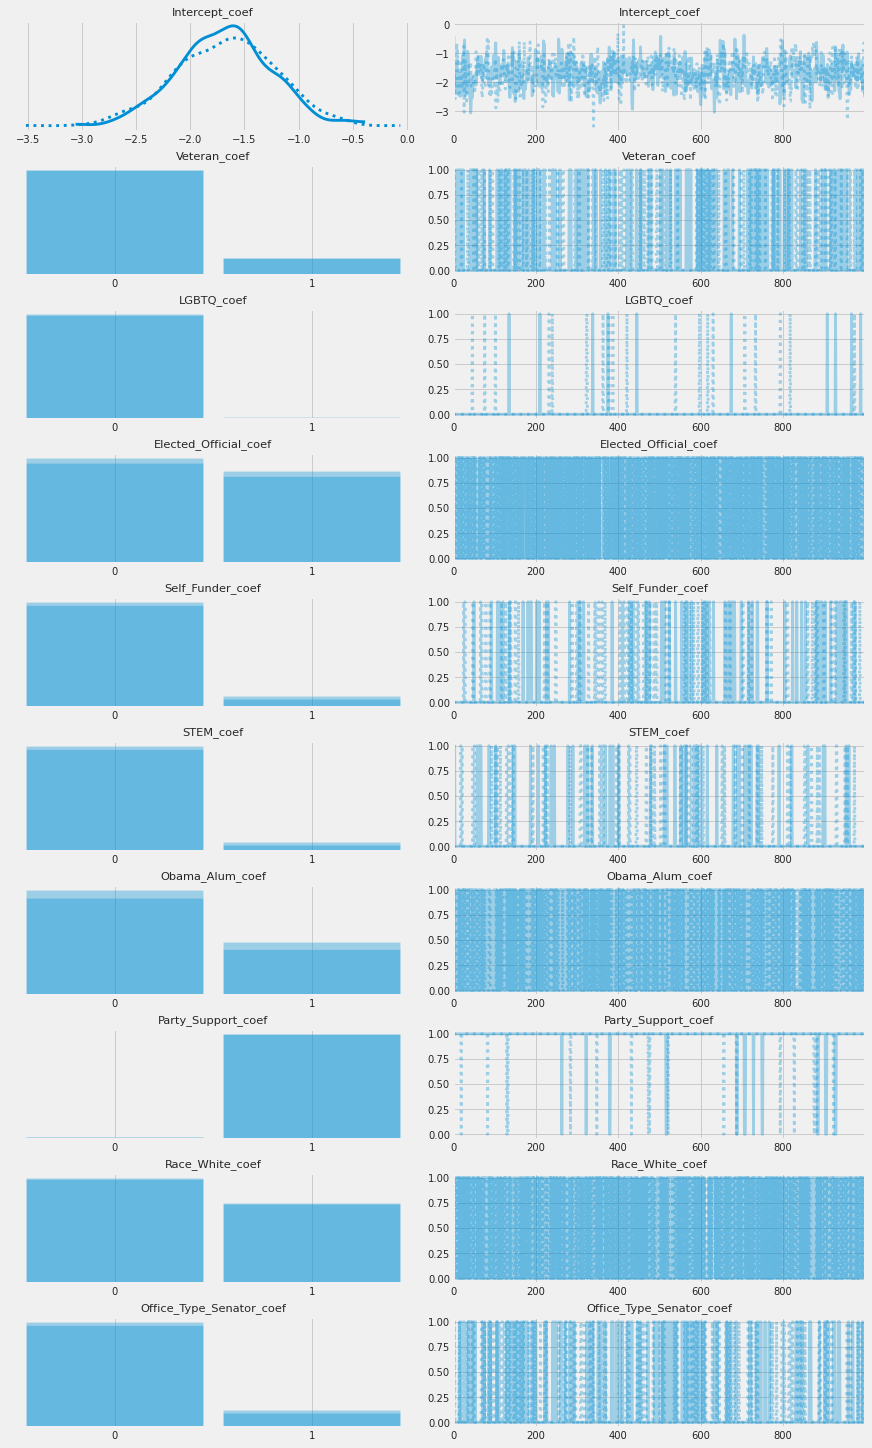

In [67]:
az.plot_trace(biden_trace);

In [68]:
with biden_model:
    biden_summary = az.summary(biden_trace)
    display(biden_summary)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept_coef           -1.678  0.451  -2.573   -0.903      0.017    0.012   
Veteran_coef              0.140  0.347   0.000    1.000      0.008    0.006   
LGBTQ_coef                0.015  0.122   0.000    0.000      0.003    0.002   
Elected_Official_coef     0.467  0.499   0.000    1.000      0.009    0.006   
Self_Funder_coef          0.087  0.282   0.000    1.000      0.007    0.005   
STEM_coef                 0.072  0.259   0.000    1.000      0.007    0.005   
Obama_Alum_coef           0.329  0.470   0.000    1.000      0.009    0.007   
Party_Support_coef        0.979  0.143   1.000    1.000      0.004    0.003   
Race_White_coef           0.432  0.496   0.000    1.000      0.010    0.007   
Office_Type_Senator_coef  0.134  0.341   0.000    1.000      0.008    0.006   

                          ess_bulk  ess_tail  r_hat  
Intercept_coef               694.0    1137.0    1.0  
Veteran_coef                1786.0    1786.0    1.0  
LGBTQ_coef                  1934.0    1934.0    1.0  
Elected_Official_coef       2957.0    2000.0    1.0  
Self_Funder_coef            1448.0    1448.0    1.0  
STEM_coef                   1262.0    1262.0    1.0  
Obama_Alum_coef             2559.0    2000.0    1.0  
Party_Support_coef          1058.0    2000.0    1.0  
Race_White_coef             2336.0    2000.0    1.0  
Office_Type_Senator_coef    1634.0    1634.0    1.0

The posterior sample means show that `Party_Support` is the most important coefficient and has a low standard deviation. Every single other coefficient is small and just going one SD away from the mean passes 0 indicating these features do not weight heavily at all in the model.

In [69]:
pd.crosstab(index=X_biden['Party_Support'], columns=y_biden)

Biden_Endorsed   0  1
Party_Support        
0               29  2
1                0  8

Party Support?&nbsp;is almost an exact proxy for&nbsp;Biden Endorsement?&nbsp;except in 2 cases.What happens if we fit a model without&nbsp;Party Support??

In [70]:
X_biden_no_party_support = X_biden.drop('Party_Support', axis=1)

with pm.Model() as biden_model_no_party_support:
    # encompass Bernoulli parameter-finding in a function 
    # to streamline specifying priors
    def p_finder(df, col):
        '''Return the average value of a column col in DataFrame df.'''
        return df[col].mean()
    # specify priors
    Intercept_prior = pm.Flat(name='Intercept_coef')
    Veteran_prior = pm.Bernoulli(p=p_finder(X_biden_no_party_support, 'Veteran'), name='Veteran_coef')
    LGBTQ_prior = pm.Bernoulli(p=p_finder(X_biden_no_party_support, 'LGBTQ'), name='LGBTQ_coef')
    Elected_Official_prior = pm.Bernoulli(p=p_finder(X_biden_no_party_support, 'Elected_Official'), name='Elected_Official_coef')
    Self_Funder_prior = pm.Bernoulli(p=p_finder(X_biden_no_party_support, 'Self_Funder'), name='Self_Funder_coef')
    STEM_prior = pm.Bernoulli(p=p_finder(X_biden_no_party_support, 'STEM'), name='STEM_coef')
    Obama_Alum_prior = pm.Bernoulli(p=p_finder(X_biden_no_party_support, 'Obama_Alum'), name='Obama_Alum_coef')
    Race_White_prior = pm.Bernoulli(p=p_finder(X_biden_no_party_support, 'Race_White'), name='Race_White_coef')
    Office_Type_Senator_prior = pm.Bernoulli(p=p_finder(X_biden_no_party_support, 'Office_Type_Senator'), name='Office_Type_Senator_coef')

    # specify likelihood
    lik = pm.invlogit(Intercept_prior +
                    Veteran_prior*X_biden_no_party_support.Veteran + LGBTQ_prior*X_biden_no_party_support.LGBTQ +
                    Elected_Official_prior*X_biden_no_party_support.Elected_Official +
                    Self_Funder_prior*X_biden_no_party_support.Self_Funder + STEM_prior*X_biden_no_party_support.STEM +
                    Obama_Alum_prior*X_biden_no_party_support.Obama_Alum + 
                    Race_White_prior*X_biden_no_party_support.Race_White + 
                    Office_Type_Senator_prior*X_biden_no_party_support.Office_Type_Senator)
    # instantiate the GLM
    pm.Bernoulli(name='Biden_Endorsement', p=lik, observed=y_biden)
    # sample from posterior
    biden_trace_no_party_support = pm.sample(draws=1000, chains=None, cores=None, 
                                            return_inferencedata=True, tune=1000)

# This cell takes approx 30 sec to run

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [Intercept_coef]
>BinaryGibbsMetropolis: [Veteran_coef, LGBTQ_coef, Elected_Official_coef, Self_Funder_coef, STEM_coef, Obama_Alum_coef, Race_White_coef, Office_Type_Senator_coef]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


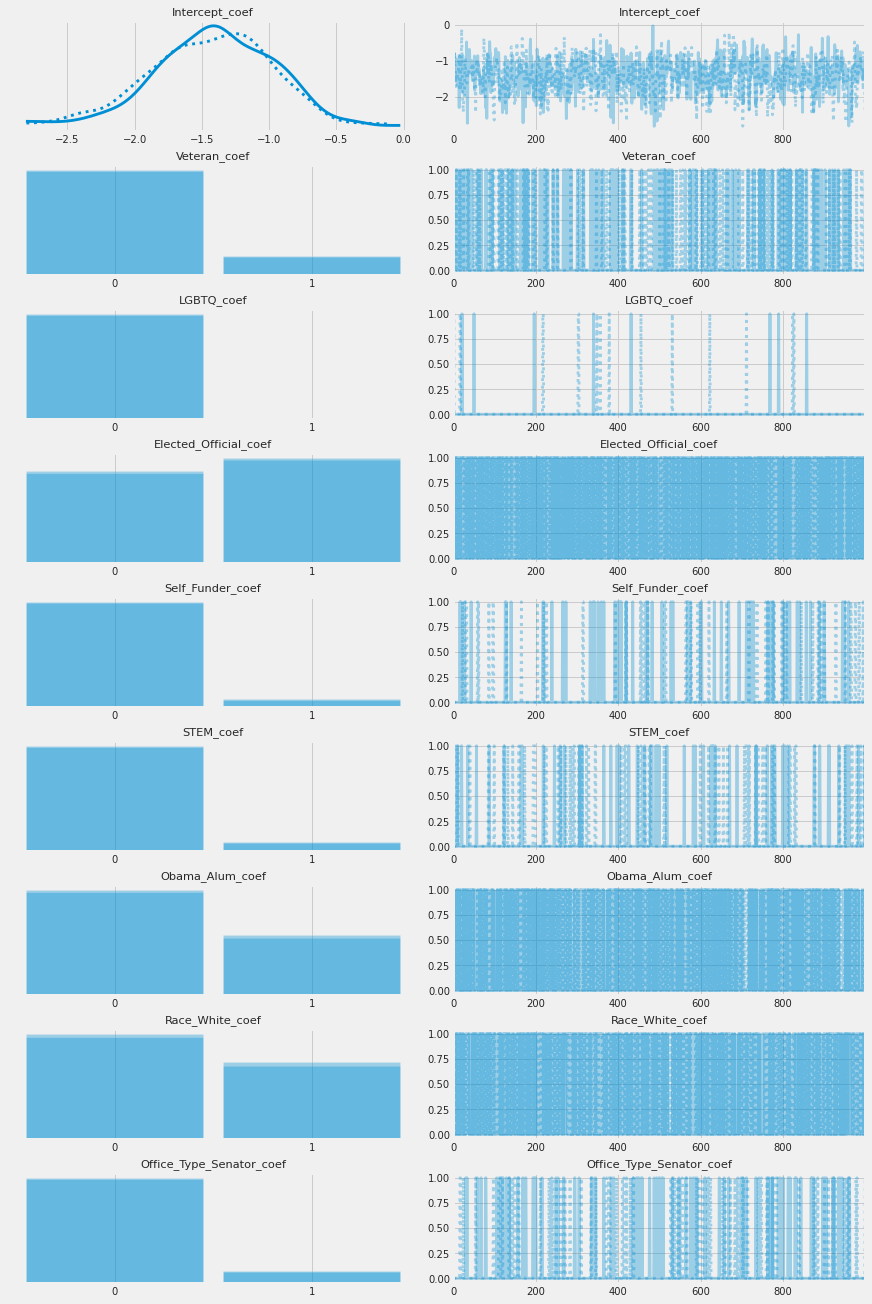

In [71]:
az.plot_trace(biden_trace_no_party_support);

In [72]:
with biden_model_no_party_support:
    biden_summary_no_party_support = az.summary(biden_trace_no_party_support)
    display(biden_summary_no_party_support)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept_coef           -1.418  0.439  -2.232   -0.619      0.016    0.011   
Veteran_coef              0.154  0.362   0.000    1.000      0.009    0.006   
LGBTQ_coef                0.012  0.109   0.000    0.000      0.003    0.002   
Elected_Official_coef     0.532  0.499   0.000    1.000      0.009    0.006   
Self_Funder_coef          0.066  0.247   0.000    1.000      0.007    0.005   
STEM_coef                 0.077  0.267   0.000    1.000      0.008    0.005   
Obama_Alum_coef           0.361  0.480   0.000    1.000      0.009    0.007   
Race_White_coef           0.422  0.494   0.000    1.000      0.010    0.007   
Office_Type_Senator_coef  0.102  0.303   0.000    1.000      0.009    0.006   

                          ess_bulk  ess_tail  r_hat  
Intercept_coef               775.0    1245.0    1.0  
Veteran_coef                1652.0    1652.0    1.0  
LGBTQ_coef                  1585.0    1585.0    1.0  
Elected_Official_coef       3120.0    2000.0    1.0  
Self_Funder_coef            1445.0    1445.0    1.0  
STEM_coef                   1177.0    1177.0    1.0  
Obama_Alum_coef             2681.0    2000.0    1.0  
Race_White_coef             2230.0    2000.0    1.0  
Office_Type_Senator_coef    1247.0    1247.0    1.0

`Elected Official?` seems to be the most important characteristic (outside of `Party Support?`) for characterizing a candidate likely to receive a Biden endorsement.

Let's examine characteristics of another Democratic endorser, Indivisible.

## Candidates endorsed by Indivisible

In [73]:
X_indivis, y_indivis = preprocess_dems(dems, column='Indivisible Endorsed?')

with pm.Model() as indivis_model:
    # encompass Bernoulli parameter-finding in a function 
    # to streamline specifying priors
    def p_finder(df, col):
        '''Return the average value of a column col in DataFrame df.'''
        return df[col].mean()
    # specify priors
    Intercept_prior = pm.Flat(name='Intercept_coef')
    Veteran_prior = pm.Bernoulli(p=p_finder(X_indivis, 'Veteran'), name='Veteran_coef')
    LGBTQ_prior = pm.Bernoulli(p=p_finder(X_indivis, 'LGBTQ'), name='LGBTQ_coef')
    Elected_Official_prior = pm.Bernoulli(p=p_finder(X_indivis, 'Elected_Official'), name='Elected_Official_coef')
    Self_Funder_prior = pm.Bernoulli(p=p_finder(X_indivis, 'Self_Funder'), name='Self_Funder_coef')
    STEM_prior = pm.Bernoulli(p=p_finder(X_indivis, 'STEM'), name='STEM_coef')
    Obama_Alum_prior = pm.Bernoulli(p=p_finder(X_indivis, 'Obama_Alum'), name='Obama_Alum_coef')
    Party_Support_prior = pm.Bernoulli(p=p_finder(X_indivis, 'Party_Support'), name='Party_Support_coef')
    Race_White_prior = pm.Bernoulli(p=p_finder(X_indivis, 'Race_White'), name='Race_White_coef')
    Office_Type_Senator_prior = pm.Bernoulli(p=p_finder(X_biden_no_party_support, 'Office_Type_Senator'), name='Office_Type_Senator_coef')

    # specify likelihood
    lik = pm.invlogit(Intercept_prior + 
                    Veteran_prior*X_indivis.Veteran + LGBTQ_prior*X_indivis.LGBTQ +
                    Elected_Official_prior*X_indivis.Elected_Official +
                    Self_Funder_prior*X_indivis.Self_Funder + STEM_prior*X_indivis.STEM +
                    Obama_Alum_prior*X_indivis.Obama_Alum + Party_Support_prior*X_indivis.Party_Support +
                    Race_White_prior*X_indivis.Race_White + 
                    Office_Type_Senator_prior*X_indivis.Office_Type_Senator)
    # instantiate the GLM
    pm.Bernoulli(name='Indivis_Endorsement', p=lik, observed=y_indivis)
    indivis_trace = pm.sample(draws=1000, chains=None, cores=None, 
                            return_inferencedata=True, tune=2000)

# This cell takes approx 30 sec to run

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [Intercept_coef]
>BinaryGibbsMetropolis: [Veteran_coef, LGBTQ_coef, Elected_Official_coef, Self_Funder_coef, STEM_coef, Obama_Alum_coef, Party_Support_coef, Race_White_coef, Office_Type_Senator_coef]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 22 seconds.
/root/venv/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The estimated number of effective samples is smaller than 200 for some parameters.


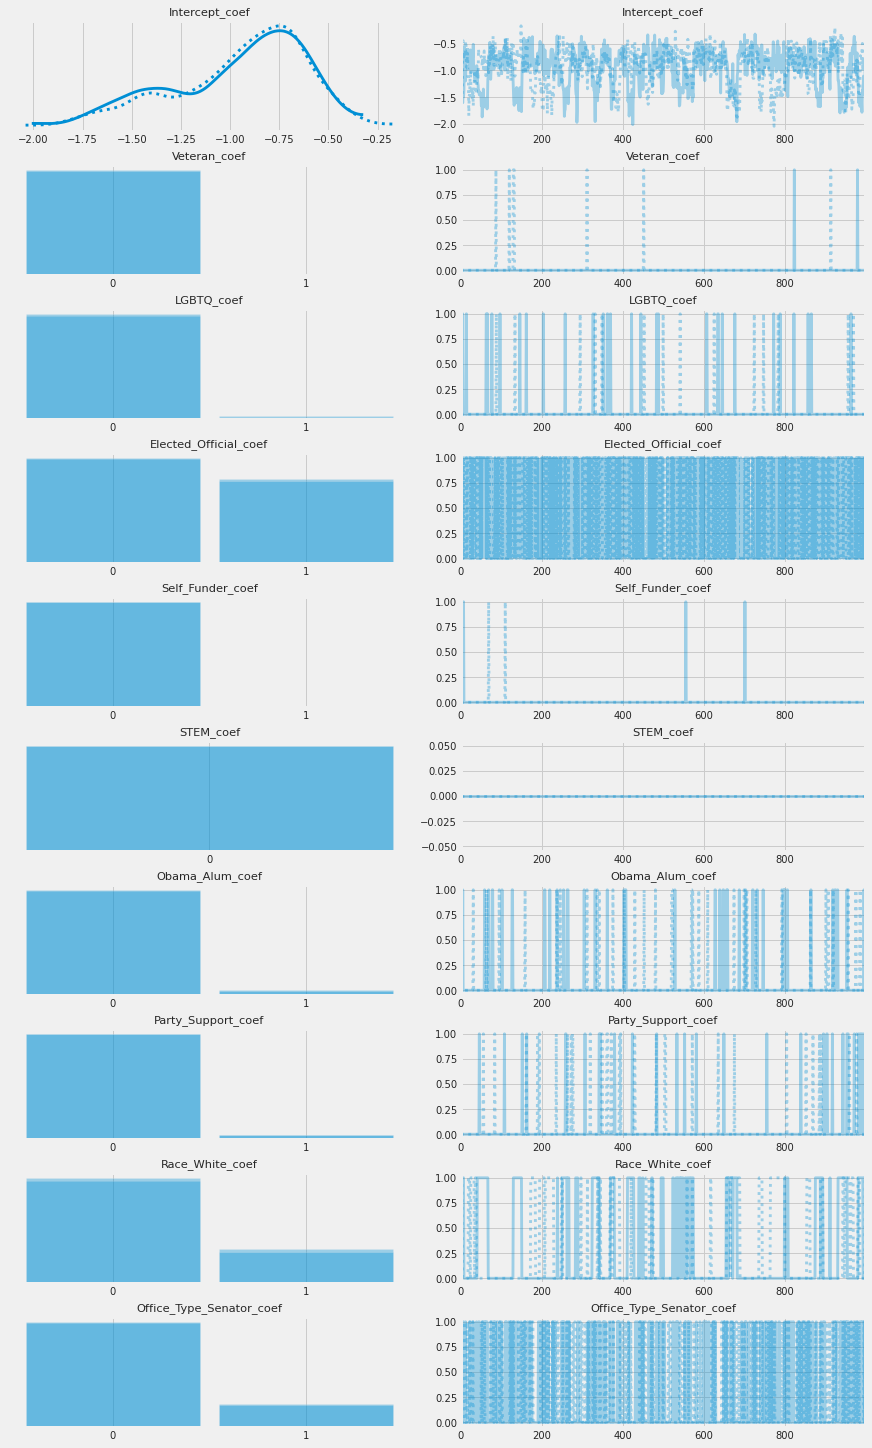

In [74]:
az.plot_trace(indivis_trace);

In [75]:
with indivis_model:
    indivis_summary = az.summary(indivis_trace)
    display(indivis_summary)

/root/venv/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept_coef           -0.952  0.338  -1.632   -0.443      0.027    0.019   
Veteran_coef              0.005  0.071   0.000    0.000      0.002    0.001   
LGBTQ_coef                0.024  0.152   0.000    0.000      0.004    0.003   
Elected_Official_coef     0.443  0.497   0.000    1.000      0.017    0.012   
Self_Funder_coef          0.002  0.050   0.000    0.000      0.001    0.001   
STEM_coef                 0.000  0.000   0.000    0.000      0.000    0.000   
Obama_Alum_coef           0.046  0.211   0.000    0.000      0.006    0.004   
Party_Support_coef        0.036  0.186   0.000    0.000      0.005    0.004   
Race_White_coef           0.240  0.427   0.000    1.000      0.034    0.024   
Office_Type_Senator_coef  0.180  0.385   0.000    1.000      0.009    0.006   

                          ess_bulk  ess_tail  r_hat  
Intercept_coef               185.0     379.0    1.0  
Veteran_coef                1273.0    1273.0    1.0  
LGBTQ_coef                  1773.0    1773.0    1.0  
Elected_Official_coef        886.0     886.0    1.0  
Self_Funder_coef            2017.0    2017.0    1.0  
STEM_coef                   2000.0    2000.0    NaN  
Obama_Alum_coef             1325.0    1325.0    1.0  
Party_Support_coef          1170.0    1170.0    1.0  
Race_White_coef              159.0     159.0    1.0  
Office_Type_Senator_coef    1767.0    1767.0    1.0

Again, whether or not the candidate is an elected official seems to be the most important factor in an Indivisible endorsement. Interestingly, the `STEM?` coefficient is 0. Just plain 0, no uncertainty.

## Round 2: What are the characteristics of races in which prominent endorsers make an endorsement?

`WORD TO THE WISE` it can take 15 min to *2.5 hours* to run *each* GLM (depending on hyperparams and how busy deepnpte is) so think twice before you run all cells!

In [76]:
races_state, races_district = pd.read_csv('data/races_state.csv'), pd.read_csv('data/races_district.csv')


## Making the design matrix (feature engineering)

Let's start by separating the features from the outcomes.

In [77]:
outcome_cols = ['Emily Endorsed?', 'Guns Sense Candidate?', 'Biden Endorsed?',
                'Warren Endorsed? ', 'Sanders Endorsed?', 'Our Revolution Endorsed?',
                'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?',
                'WFP Endorsed?', 'VoteVets Endorsed?', 'No Labels Support?',
                'Trump Endorsed?', 'Bannon Endorsed?', 'Great America Endorsed?',
                'NRA Endorsed?', 'Right to Life Endorsed?', 'Susan B. Anthony Endorsed?',
                'Club for Growth Endorsed?', 'Koch Support?', 'House Freedom Support?',
                'Tea Party Endorsed?', 'Main Street Endorsed?', 'Chamber Endorsed?']

X_state, Y_state = races_state.drop(['Name','State_abbrev','State_num', ]+outcome_cols, axis=1), races_state[outcome_cols]
X_district, Y_district = races_district.drop(['Name','State_abbrev','State_num','Congressional_District']+outcome_cols, axis=1), races_district[outcome_cols]

# combine state and district races into one dataframe
X, Y = X_state.append(X_district), Y_state.append(Y_district)

# OHE the office type
X = pd.concat([X, pd.get_dummies(X["Office Type"], prefix='Office', drop_first=True)], axis=1).drop(["Office Type"], axis=1)
full_df = pd.concat([X,Y], axis=1)
full_df

Total_Population  Race_White  Race_Black  Race_AmerInd  Race_Asian  \
0              737438      474555       25197        111371       46381   
1             4887871     3306838     1307040         22063       65095   
2             3013825     2306096      456714         20951       47548   
3             7171646     5590505      336340        330599      237873   
4            39557045    23535388     2283850        302792     5821585   
..                ...         ...         ...           ...         ...   
358            724568      674388        7846          3486       17386   
359            710573      351094      234575          3294       31139   
360            606136      569483       16341           833        5765   
361            624120      571744       28834          1352        5377   
362            575576      538546       23504           444        2317   

     Race_PacIsl  Race_Other  Race_TwoOrMore  Agg_Household_Income  \
0           7958        9780           62196           24457350200   
1           1797       84027          101011          128176358800   
2           9398       84917           88201           77205193600   
3          15661      373688          286980          210390307500   
4         155739     5453229         2004462         1403732564500   
..           ...         ...             ...                   ...   
358          142        7457           13863           21000664400   
359          268       59336           30867           17894249000   
360           13        1988           11713           15696908300   
361          269        3319           13225           17080413600   
362          169        1123            9473           12558654000   

     Inc_Pov_Ratio_below_50  ...  Great America Endorsed?  NRA Endorsed?  \
0                     37710  ...                        0              0   
1                    363398  ...                        0              0   
2                    196541  ...                        0              0   
3                    440556  ...                        1              0   
4                   2275195  ...                        0              1   
..                      ...  ...                      ...            ...   
358                   41579  ...                        0              0   
359                   64525  ...                        0              0   
360                   47469  ...                        0              0   
361                   33671  ...                        0              0   
362                   51611  ...                        0              0   

     Right to Life Endorsed?  Susan B. Anthony Endorsed?  \
0                          0                           0   
1                          0                           0   
2                          0                           0   
3                          0                           1   
4                          1                           1   
..                       ...                         ...   
358                        1                           0   
359                        1                           0   
360                        0                           0   
361                        0                           0   
362                        0                           1   

     Club for Growth Endorsed?  Koch Support?  House Freedom Support?  \
0                            0              0                       0   
1                            0              0                       0   
2                            0              0                       0   
3                            1              1                       1   
4                            0              0                       0   
..                         ...            ...                     ...   
358                          0              0                       0   
359                          0              0

Now we can perform feature engineering to produce a design matrix.

In [78]:
def make_design_matrix(df):
    '''Prepare a design matrix to pass to a GLM.
    
    df: X as defined above
    
    returns: design matrix X
    '''
    X = df.copy()
    # drop features we don't like anymore
    cols_to_drop = ['Inc_Pov_Ratio_below_50', 'Inc_Pov_Ratio_50_74',
       'Inc_Pov_Ratio_75_99', 'Inc_Pov_Ratio_100_124', 'Inc_Pov_Ratio_125_149',
       'Inc_Pov_Ratio_150_174', 'Inc_Pov_Ratio_175_184',
       'Inc_Pov_Ratio_185_199', 'Inc_Pov_Ratio_200_299',
       'Inc_Pov_Ratio_300_399', 'Inc_Pov_Ratio_400_499',
       'Inc_Pov_Ratio_above_500', 'Age_18_19', 'Age_20', 'Age_21', 'Age_22_24',
       'Age_25_29', 'Age_30_34', 'Age_35_39', 'Age_40_44', 'Age_45_49',
       'Age_50_54', 'Age_55_59', 'Age_60_61', 'Age_62_64', 'Age_65_66',
       'Age_67_69', 'Age_70_74', 'Age_75_79', 'Age_80_84', 'Age_85_over']
    X = X.drop(cols_to_drop, axis=1)
    # map binary categorical columns to 0-1
    X['lean_party'] = X['lean_party'].apply(lambda x: 1 if x == 'D' else 0)
    # turn population-related columns into percent of total pop
    pop_cols = ['Race_White', 'Race_Black', 'Race_AmerInd',
       'Race_Asian', 'Race_PacIsl', 'Race_Other', 'Race_TwoOrMore',
       'Agg_Household_Income']
    for c in pop_cols:
        X[c] = X[c] / X['Total_Population']
    X = X.rename({'Agg_Household_Income':'Avg_Per_Cap_Income'}, axis=1)
    # normalize all continuous numeric columns to be between 0 and 1
    X = (X - X.min()) / (X.max() - X.min())
    return X

## Visualizing the distributions of each feature in the location data

In order to pick informed priors we need to identify distributions and parameters for each feature.

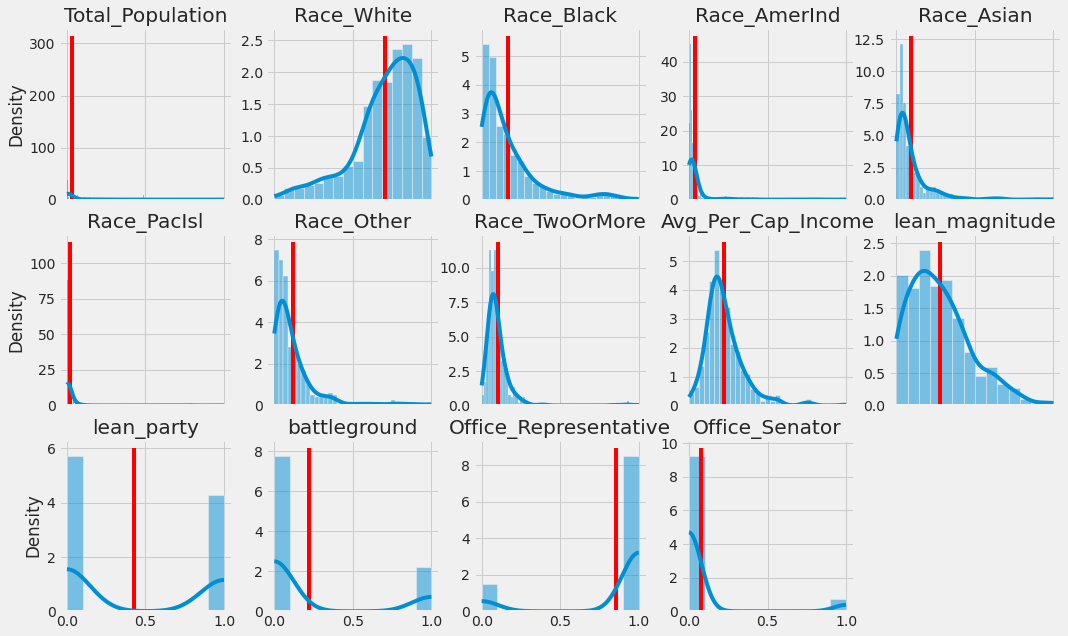

In [79]:
design_matrix = make_design_matrix(X)

num_cols = 5
num_rows = int(np.ceil(design_matrix.shape[1] / num_cols))

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, figsize=(16,10))
axs = axs.flatten()

feature_means = {}

for i,col in enumerate(design_matrix.columns):
    ax = axs[i]
    data = design_matrix[col]
    sns.histplot(x=data, stat='density', kde=True, ax=ax)
    ax.vlines(data.mean(), ymin=0, ymax=ax.get_ylim()[1], colors='red')
    feature_means[col] = data.mean()
    ax.set_title(col)
    if i % 5:
        ax.set_ylabel('')
    if i >= design_matrix.shape[1] - (num_rows-1)*design_matrix.shape[1]:
        ax.set_xlabel('')

for i in range(design_matrix.shape[1], num_rows*num_cols):
    ax = axs[i]
    ax.axis('off')
plt.savefig('images/distributions_of_features.png');

# takes about 15 sec to run

## Some More EDA: Correlation Heatmap

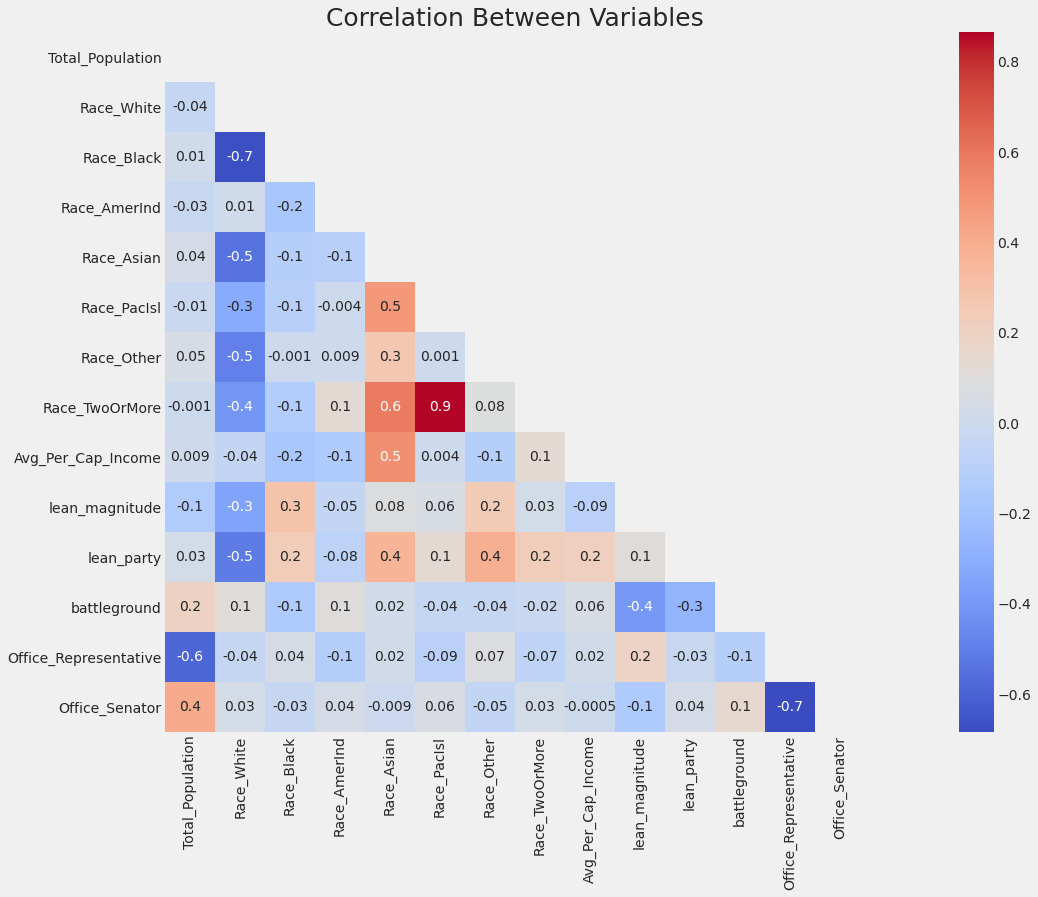

In [80]:
df = design_matrix
tri_mask = np.triu(df.corr())
fig, ax = plt.subplots(figsize=(30,12))
sns.heatmap(df.corr(), annot=True, fmt='.1g', cmap='coolwarm',
            square=True, mask=tri_mask)
ax.set_title('Correlation Between Variables',  fontsize=25)
plt.savefig('images/corr_heatmap.png');

## GLM 1: Our Revolution endorsement

In [81]:
# hyperparams for all 4 GLM's
num_chains = 4
num_samples = 2000
num_tunes = 2500
num_accept = 0.9

# string to append to pickles and image outputs
save_appendage = '_4_chains_2k_samples'

# drop last-min features based on corr heatmap
X_1 = design_matrix.drop('Race_TwoOrMore', axis=1)


# %%time
# y_1 = Y['Our Revolution Endorsed?']
# data = pd.concat([X_1, y_1], axis=1).rename({'Our Revolution Endorsed?':'our_rev_end'}, axis=1)

# with pm.Model() as our_rev_model:
#     formula = 'our_rev_end' + " ~ " + " + ".join(data.columns[:-1])
#     pm.glm.GLM.from_formula(
#             formula,
#             data,
#             family=pm.glm.families.Binomial()
#         )
#     our_rev_trace = pm.sample(num_samples, chains=num_chains, tune=num_tunes, target_accept=num_accept, cores=None, return_inferencedata=True)

# fig = plt.figure()
# ax = az.plot_trace(our_rev_trace);
# plt.savefig('images/trace_our_rev'+save_appendage+'.png')


def add_significance_indicator(data):
    '''Prepare a pymc3 trace summary DataFrame to display.'''
    data = data[['mean', 'sd', 'hdi_3%', 'hdi_97%']].copy()
    upper, lower = data['hdi_97%'], data['hdi_3%']
    sig = [not((u > 0) and (l < 0)) if u>l else not((u < 0) and (l > 0)) for u,l in zip(upper, lower)]
    data['Significant?'] = ['Yes' if x else 'No' for x in sig]
    return data
    
# with open('pickle_jar/our_rev_trace'+save_appendage+'.pkl', 'wb') as f:     
#        pickle.dump(our_rev_trace, f)


with open('pickle_jar/our_rev_trace_4_chains_2k_samples.pkl', 'rb') as f:
    our_rev_trace = pickle.load(f)

our_rev_summary = add_significance_indicator(pm.summary(our_rev_trace))
our_rev_summary

mean      sd  hdi_3%  hdi_97% Significant?
Intercept               6.105  10.028 -13.326   24.094           No
Total_Population        6.873   2.827   1.812   12.159          Yes
Race_White             -5.177   9.995 -23.422   13.824           No
Race_Black             -4.685   8.458 -20.096   11.561           No
Race_AmerInd           -2.427   3.809  -9.762    4.411           No
Race_Asian             -2.159   7.619 -16.112   12.287           No
Race_PacIsl           -10.445   7.851 -25.818    3.379           No
Race_Other             -1.474   5.044 -10.710    8.249           No
Avg_Per_Cap_Income     -1.270   1.695  -4.387    1.972           No
lean_magnitude         -2.318   0.886  -3.930   -0.617          Yes
lean_party             -1.325   0.359  -1.991   -0.626          Yes
battleground           -0.150   0.343  -0.762    0.518           No
Office_Representative  -1.195   0.560  -2.302   -0.186          Yes
Office_Senator         -0.574   0.625  -1.734    0.616           No

In [83]:
our_rev_summary.to_csv('pickle_jar/our_rev_summary'+save_appendage+'.csv')
our_rev_summary = pd.read_csv('pickle_jar/our_rev_summary_4_chains_2k_samples.csv', index_col='Unnamed: 0')
print(our_rev_summary.to_latex())

\begin{tabular}{lrrrrl}
\toprule
{} &    mean &      sd &  hdi\_3\% &  hdi\_97\% & Significant? \\
\midrule
Intercept             &   6.105 &  10.028 & -13.326 &   24.094 &           No \\
Total\_Population      &   6.873 &   2.827 &   1.812 &   12.159 &          Yes \\
Race\_White            &  -5.177 &   9.995 & -23.422 &   13.824 &           No \\
Race\_Black            &  -4.685 &   8.458 & -20.096 &   11.561 &           No \\
Race\_AmerInd          &  -2.427 &   3.809 &  -9.762 &    4.411 &           No \\
Race\_Asian            &  -2.159 &   7.619 & -16.112 &   12.287 &           No \\
Race\_PacIsl           & -10.445 &   7.851 & -25.818 &    3.379 &           No \\
Race\_Other            &  -1.474 &   5.044 & -10.710 &    8.249 &           No \\
Avg\_Per\_Cap\_Income    &  -1.270 &   1.695 &  -4.387 &    1.972 &           No \\
lean\_magnitude        &  -2.318 &   0.886 &  -3.930 &   -0.617 &          Yes \\
lean\_party            &  -1.325 &   0.359 &  -1.991 &   -0.626 &      

## GLM 2: Biden endorsement

In [84]:
# %%time
# y_2 = Y['Biden Endorsed?']
# data = pd.concat([X_1, y_2], axis=1).rename({'Biden Endorsed?':'biden_end'}, axis=1)

# with pm.Model() as biden_model:
#     formula = 'biden_end' + " ~ " + " + ".join(data.columns[:-1])
#     pm.glm.GLM.from_formula(
#             formula,
#             data,
#             family=pm.glm.families.Binomial()
#         )
#     biden_trace = pm.sample(num_samples, chains=num_chains, tune=num_tunes, target_accept=num_accept, cores=None, return_inferencedata=True)

# plt.figure()
# ax = az.plot_trace(biden_trace)
# plt.savefig('images/trace_biden'+save_appendage+'.png');

with open('pickle_jar/biden_trace_4_chains_2k_samples.pkl', 'rb') as f:
    biden_trace = pickle.load(f)

biden_summary = add_significance_indicator(pm.summary(biden_trace))
biden_summary

# with open('pickle_jar/biden_trace'+save_appendage+'.pkl', 'wb') as f:      
#        pickle.dump(biden_trace, f)
biden_summary.to_csv('pickle_jar/biden_summary'+save_appendage+'.csv')

biden_summary = pd.read_csv('pickle_jar/biden_summary_4_chains_2k_samples.csv', index_col='Unnamed: 0')

print(biden_summary.to_latex())


## GLM 3: Trump endorsement

In [85]:
# %%time
# y_3 = Y['Trump Endorsed?']
# data = pd.concat([X_1, y_3], axis=1).rename({'Trump Endorsed?':'trump_end'}, axis=1)

# with pm.Model() as trump_model:
#     formula = 'trump_end' + " ~ " + " + ".join(data.columns[:-1])
#     pm.glm.GLM.from_formula(
#             formula,
#             data,
#             family=pm.glm.families.Binomial()
#         )
#     trump_trace = pm.sample(num_samples, chains=num_chains, tune=num_tunes, target_accept=num_accept, cores=None, return_inferencedata=True)

# plt.figure()
# ax = az.plot_trace(trump_trace)
# plt.savefig('images/trace_trump'+save_appendage+'.png');

with open('pickle_jar/trump_trace_4_chains_2k_samples.pkl', 'rb') as f:
    trump_trace = pickle.load(f)

trump_summary = add_significance_indicator(pm.summary(trump_trace))
trump_summary

# with open('pickle_jar/trump_trace'+save_appendage+'.pkl', 'wb') as f:     
#        pickle.dump(trump_trace, f)
trump_summary.to_csv('pickle_jar/trump_summary'+save_appendage+'.csv')

trump_summary = pd.read_csv('pickle_jar/trump_summary_4_chains_2k_samples.csv', index_col='Unnamed: 0')

print(trump_summary.to_latex())

\begin{tabular}{lrrrrl}
\toprule
{} &    mean &      sd &  hdi\_3\% &  hdi\_97\% & Significant? \\
\midrule
Intercept             &  23.127 &  37.147 & -47.865 &   92.456 &           No \\
Total\_Population      &   0.410 &   2.085 &  -3.454 &    4.360 &           No \\
Race\_White            & -22.668 &  37.119 & -92.186 &   47.658 &           No \\
Race\_Black            & -21.884 &  31.276 & -81.308 &   37.102 &           No \\
Race\_AmerInd          & -16.776 &  13.752 & -42.056 &    9.923 &           No \\
Race\_Asian            & -15.022 &  28.393 & -67.994 &   38.284 &           No \\
Race\_PacIsl           & -18.905 &  20.813 & -57.487 &   20.867 &           No \\
Race\_Other            & -14.694 &  19.577 & -51.359 &   22.258 &           No \\
Avg\_Per\_Cap\_Income    &  -3.705 &   6.591 & -15.974 &    8.444 &           No \\
lean\_magnitude        &  -1.674 &   2.759 &  -6.717 &    3.717 &           No \\
lean\_party            &  -0.441 &   0.878 &  -2.015 &    1.325 &      

## GLM 4: Tea Party endorsement

In [86]:
# %%time
# y_4 = Y['Tea Party Endorsed?']
# data = pd.concat([X_1, y_4], axis=1).rename({'Tea Party Endorsed?':'tea_party_end'}, axis=1)

# with pm.Model() as tea_party_model:
#     formula = 'tea_party_end' + " ~ " + " + ".join(data.columns[:-1])
#     pm.glm.GLM.from_formula(
#             formula,
#             data,
#             family=pm.glm.families.Binomial()
#         )
#     tea_party_trace = pm.sample(num_samples, chains=num_chains, tune=num_tunes, target_accept=num_accept, cores=None, return_inferencedata=True)

# fig = plt.figure()
# ax = az.plot_trace(tea_party_trace)
# plt.savefig('images/trace_tea_party'+save_appendage+'.png');

with open('pickle_jar/tea_party_trace_4_chains_2k_samples.pkl', 'rb') as f:
    tea_party_trace = pickle.load(f)

tea_party_summary = add_significance_indicator(pm.summary(tea_party_trace))
tea_party_summary

# with open('pickle_jar/tea_party_trace'+save_appendage+'.pkl', 'wb') as f:  
#        pickle.dump(tea_party_trace, f)
tea_party_summary.to_csv('pickle_jar/tea_party_summary'+save_appendage+'.csv')

tea_party_summary = pd.read_csv('pickle_jar/tea_party_summary_4_chains_2k_samples.csv', index_col='Unnamed: 0')

print(tea_party_summary.to_latex())

\begin{tabular}{lrrrrl}
\toprule
{} &    mean &      sd &  hdi\_3\% &  hdi\_97\% & Significant? \\
\midrule
Intercept             & -17.099 &  21.447 & -57.951 &   22.980 &           No \\
Total\_Population      &   9.103 &   2.786 &   4.146 &   14.486 &          Yes \\
Race\_White            &  12.952 &  21.416 & -27.734 &   53.042 &           No \\
Race\_Black            &  11.726 &  17.945 & -19.422 &   47.831 &           No \\
Race\_AmerInd          &   7.669 &   7.150 &  -5.305 &   21.451 &           No \\
Race\_Asian            &  14.042 &  15.924 & -14.387 &   45.275 &           No \\
Race\_PacIsl           &  -6.618 &  16.517 & -39.171 &   22.665 &           No \\
Race\_Other            &   6.652 &  11.044 & -14.250 &   27.379 &           No \\
Avg\_Per\_Cap\_Income    &  -0.616 &   3.460 &  -7.038 &    5.830 &           No \\
lean\_magnitude        &  -3.450 &   2.033 &  -7.359 &    0.138 &           No \\
lean\_party            &  -2.145 &   0.825 &  -3.694 &   -0.639 &      

## Open the pickle jar

In [87]:
# test_trace = pickle.load(open('biden_trace.pkl', 'rb'))
# print(pm.summary(test_trace)[["mean", "sd", "hdi_3%", "hdi_97%"]].to_latex())

# # %%time
# y_3 = Y['Trump Endorsed?']
# data = pd.concat([X_1, y_3], axis=1).rename({'Trump Endorsed?':'trump_end'}, axis=1)

# with pm.Model() as trump_model:
#         formula = 'trump_end' + " ~ " + " + ".join(data.columns[:-1])
#         pm.glm.GLM.from_formula(
#                 formula,
#                 data,
#                 family=pm.glm.families.Binomial()
#                 )
#         pm.model_to_graphviz(trump_model)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (6 chains in 1 job)
NUTS: [Agg_Household_Income, lean_party, lean_magnitude, battleground, Office_Senator, Office_Representative, Intercept]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 86 seconds.


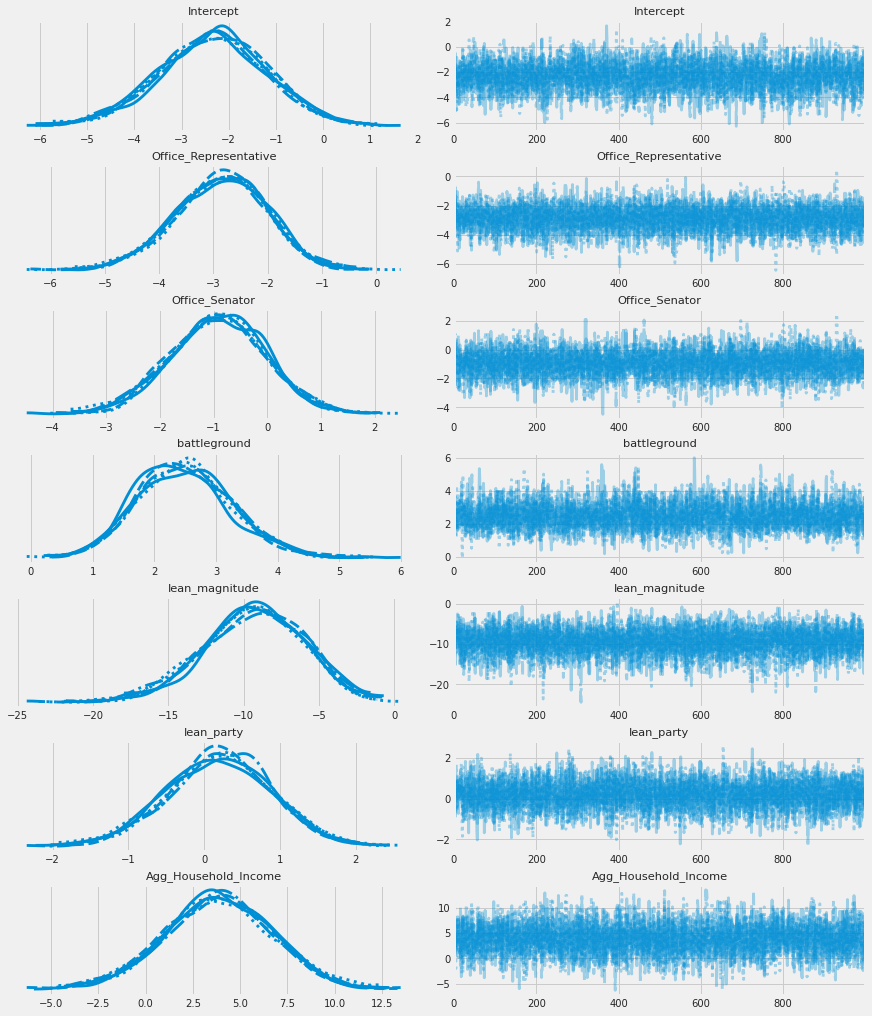

In [88]:
def get_endorser(columns):
    '''
    Takes in an iterable of column names and returns a
    list of column names that are compatible with formulas
    '''

    result = []
    for i in range(len(columns)):
        if "Endorsed" in columns[i]:
            new_string = "".join(columns[i].split()[0:-1]).lower()
            new_string = new_string.replace("?","")
            new_string = new_string.replace(".","")
            result += [new_string]
        else:
            new_string = columns[i]
            new_string = new_string.replace(" ","_")
            new_string = new_string.replace("?","")
            new_string = new_string.replace(".","")
            result += [new_string]
    return result

searchfor = ["battleground","Office_", "lean_party", "Endorsed", "Support", "\?"]
boolean_columns = full_df.columns[full_df.columns.str.contains('|'.join(searchfor))]
boolean_columns = get_endorser(boolean_columns)
renamed_df = full_df.copy()
renamed_df.columns = get_endorser(renamed_df.columns)


def normalize_df(df, ignore=[]):
    X = df.copy()
    pop_cols = ['Race_White', 'Race_Black', 'Race_AmerInd',
        'Race_Asian', 'Race_PacIsl', 'Race_Other', 'Race_TwoOrMore',
        'Agg_Household_Income', 'Inc_Pov_Ratio_below_50', 'Inc_Pov_Ratio_50_74',
        'Inc_Pov_Ratio_75_99', 'Inc_Pov_Ratio_100_124', 'Inc_Pov_Ratio_125_149',
        'Inc_Pov_Ratio_150_174', 'Inc_Pov_Ratio_175_184',
        'Inc_Pov_Ratio_185_199', 'Inc_Pov_Ratio_200_299',
        'Inc_Pov_Ratio_300_399', 'Inc_Pov_Ratio_400_499',
        'Inc_Pov_Ratio_above_500', 'Age_18_19', 'Age_20', 'Age_21', 'Age_22_24',
        'Age_25_29', 'Age_30_34', 'Age_35_39', 'Age_40_44', 'Age_45_49',
        'Age_50_54', 'Age_55_59', 'Age_60_61', 'Age_62_64', 'Age_65_66',
        'Age_67_69', 'Age_70_74', 'Age_75_79', 'Age_80_84', 'Age_85_over']           
    # map binary categorical columns to 0-1
    X['lean_party'] = X['lean_party'].apply(lambda x: 1 if x == 'D' else 0)
    # turn population-related columns into percent of total pop
    
    for c in pop_cols:
        X[c] = X[c] / X['Total_Population']
    # normalize all continuous numeric columns to be between 0 and 1
    for column in X.columns:
        if column not in ignore:
            X[column] = (X[column] - X[column].min()) / (X[column].max() - X[column].min())
    return X


final_df = normalize_df(renamed_df, boolean_columns)


def get_trace(candidate, df):
    candidate = candidate.lower()
    variables = ["Office_Representative", "Office_Senator", "battleground", 'lean_magnitude', 'lean_party', 'Agg_Household_Income']
    formula = candidate + " ~ " + " + ".join(variables)
    with pm.Model() as logistic_model:
        pm.glm.GLM.from_formula(
            formula,
            df,
            family=pm.glm.families.Binomial()
        )
        trace = pm.sample(1000, chains=6, cores=None, init="adapt_diag", target_accept=0.8, return_inferencedata=True)
    az.plot_trace(trace)
    return trace


jacks_trace = get_trace("Biden", final_df)
# Saved traces via pickling just in case we want it later.

import pickle
with open('jacks_trace.pkl', 'wb') as f:  
    pickle.dump(jacks_trace, f)
#with open('trump_trace.pkl', 'wb') as f:     
#        pickle.dump(trump_trace, f)
#with open('biden_trace.pkl', 'wb') as f:      
#        pickle.dump(trump_trace, f)
#with open('our_rev_trace.pkl', 'wb') as f:     
        #pickle.dump(our_rev_trace, f)

#test_trace = pickle.load(open('biden_trace.pkl', 'rb'))
#az.plot_trace(test_trace);

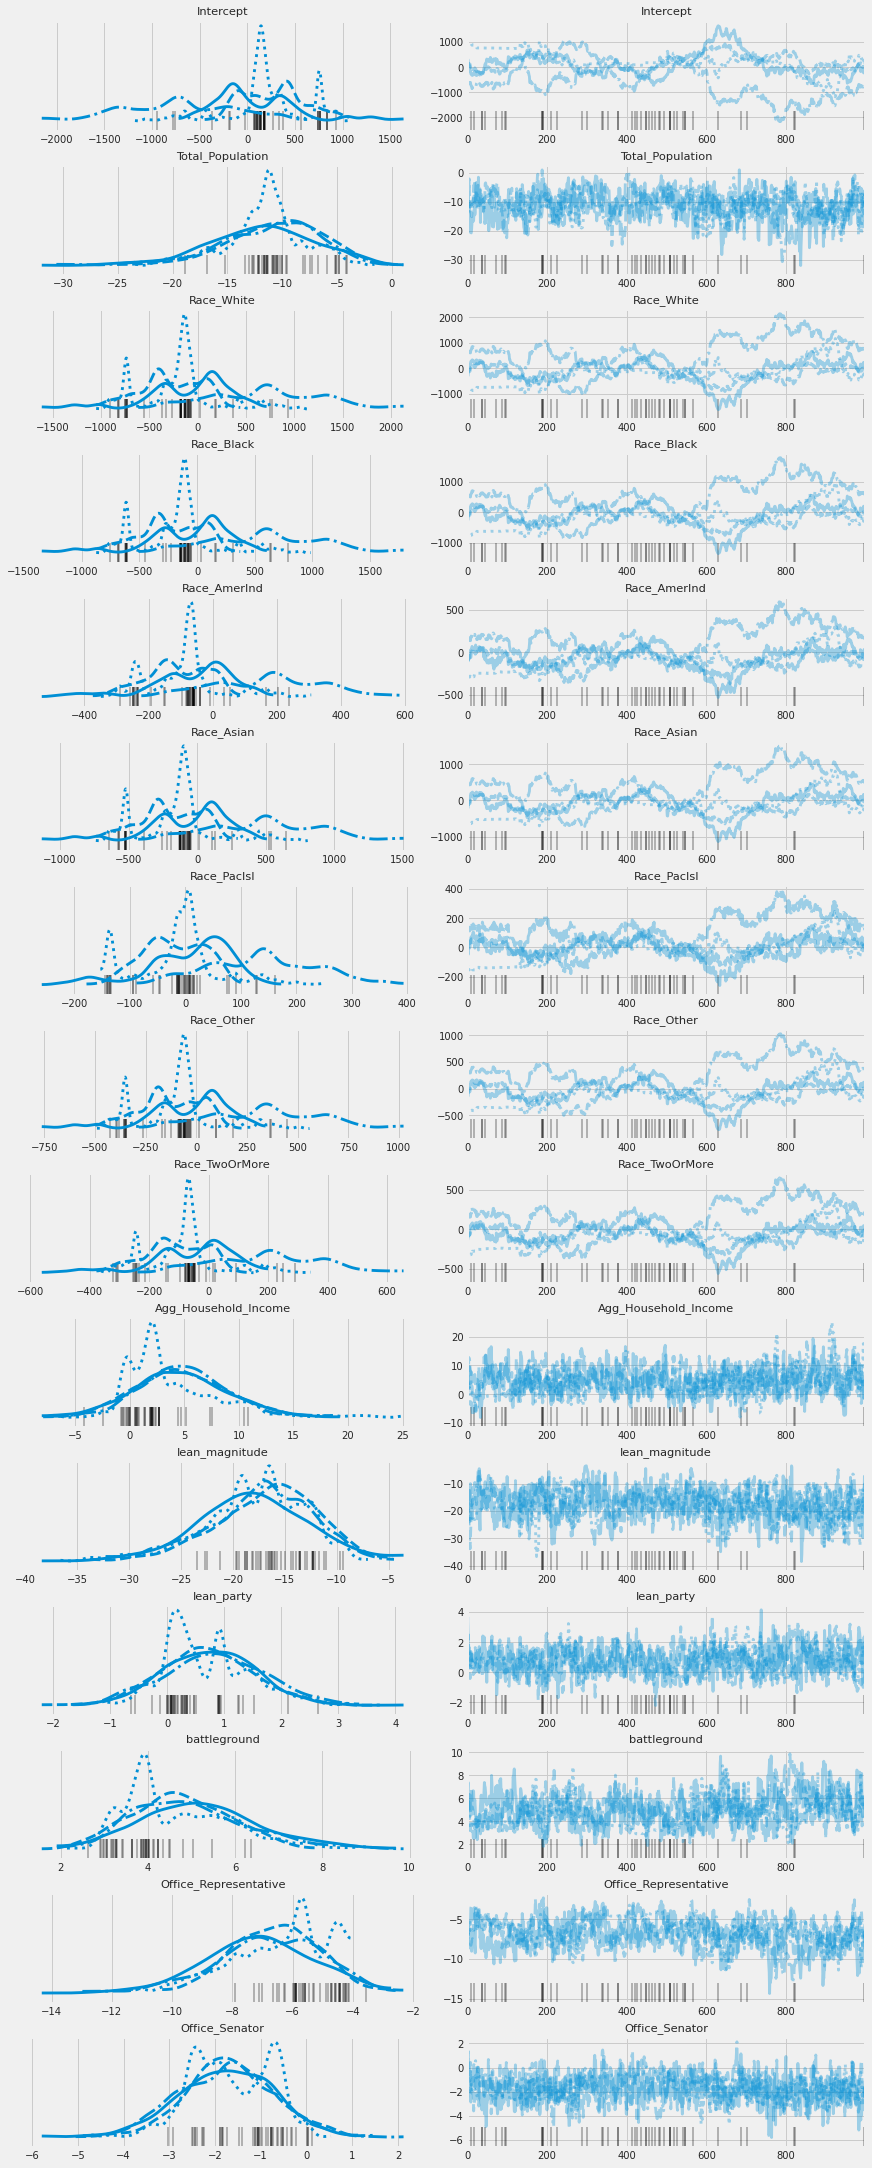

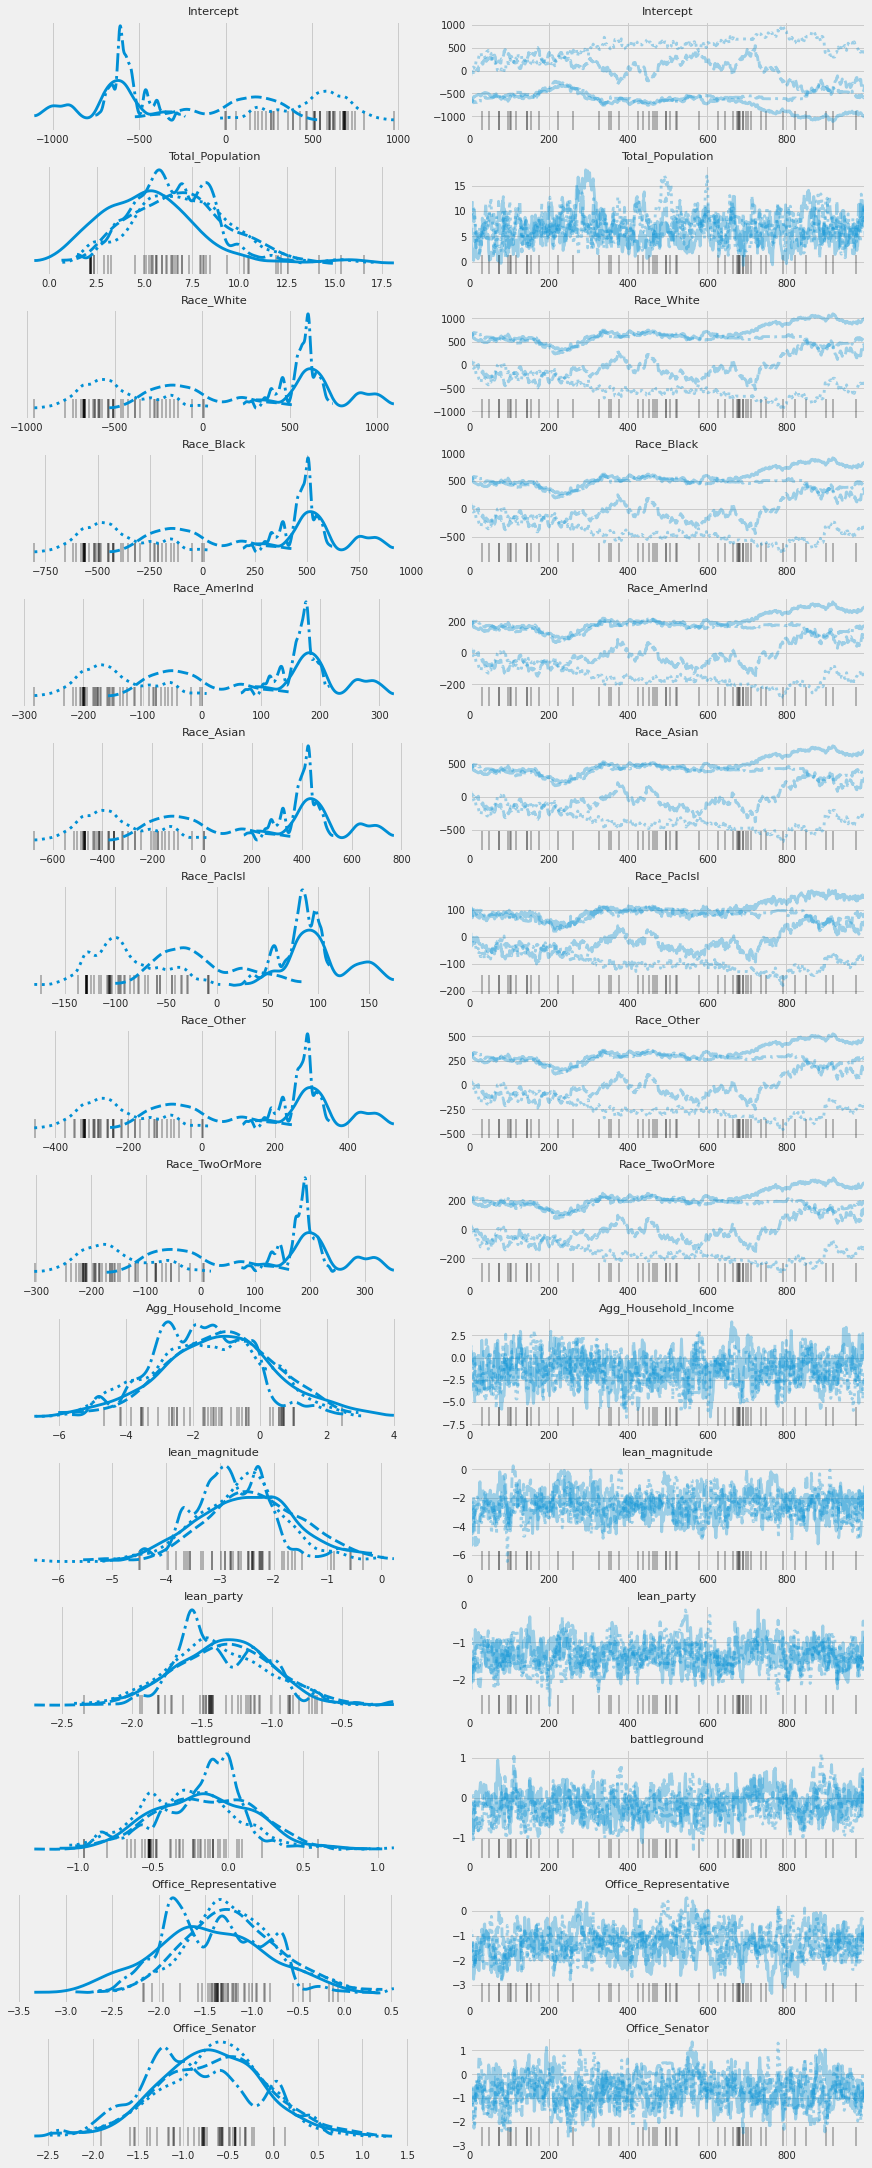

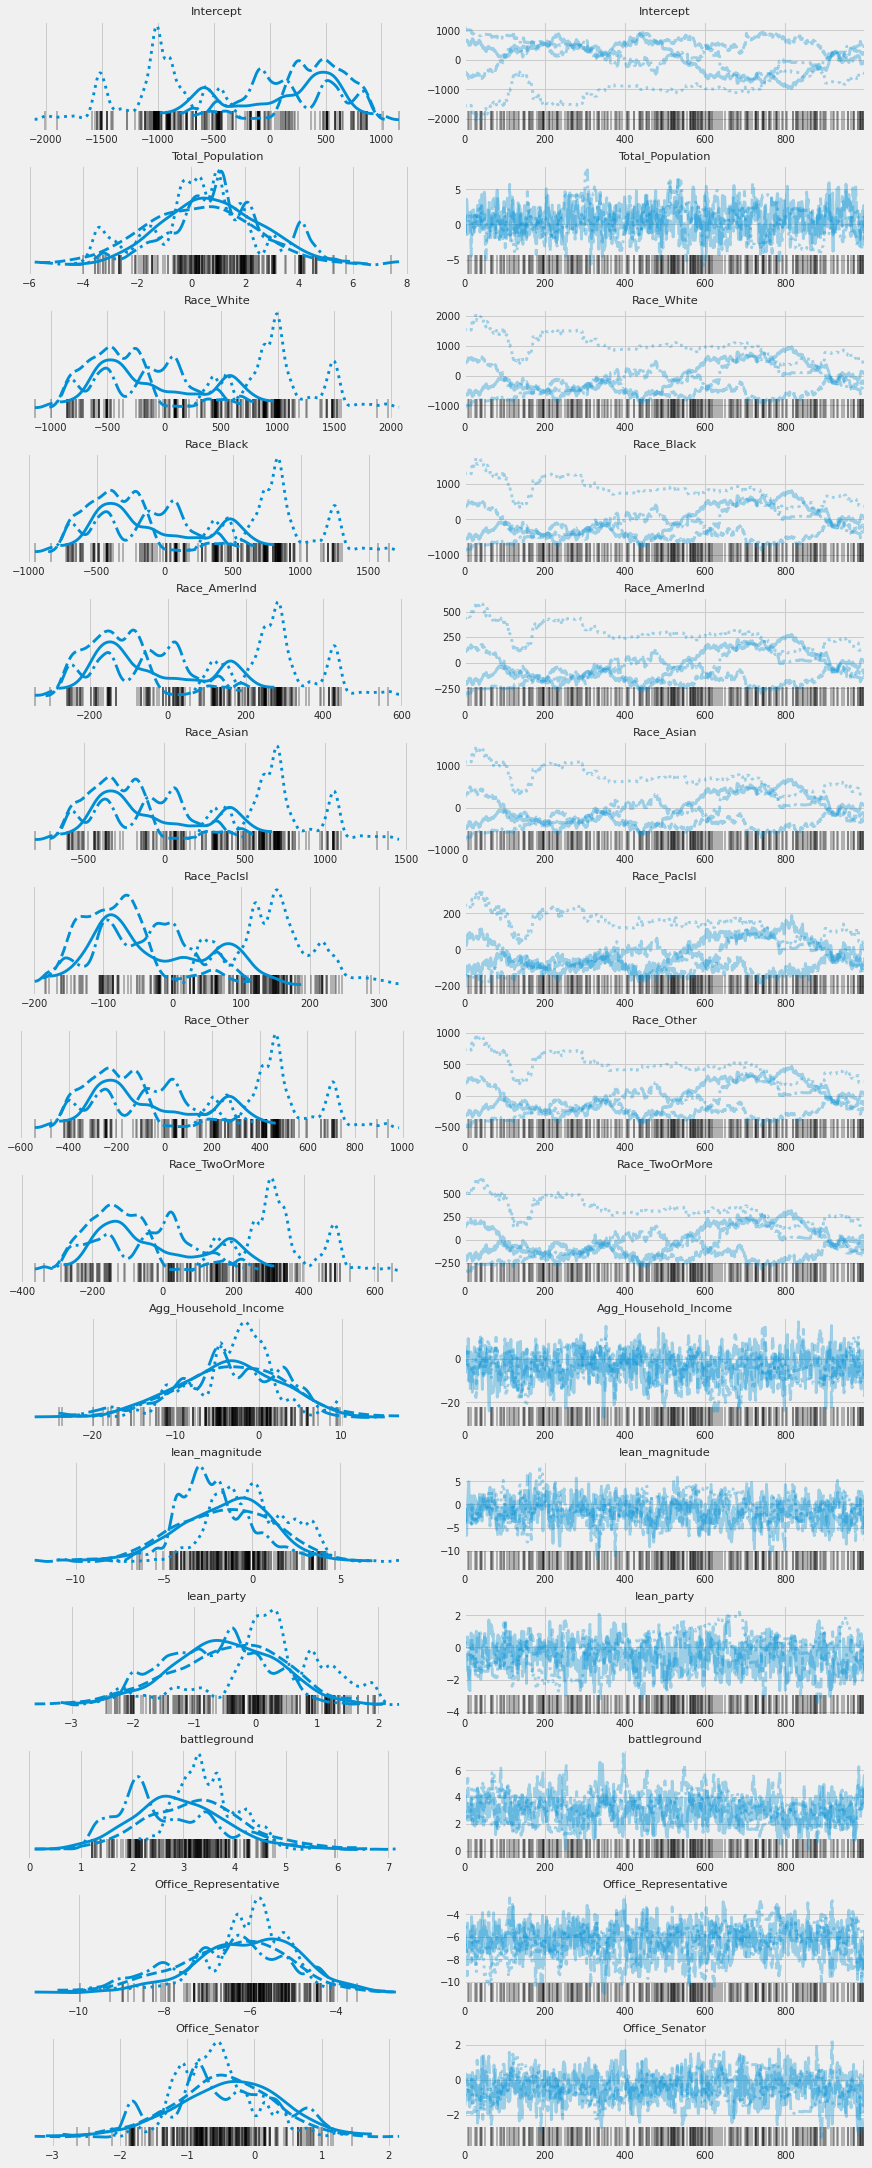

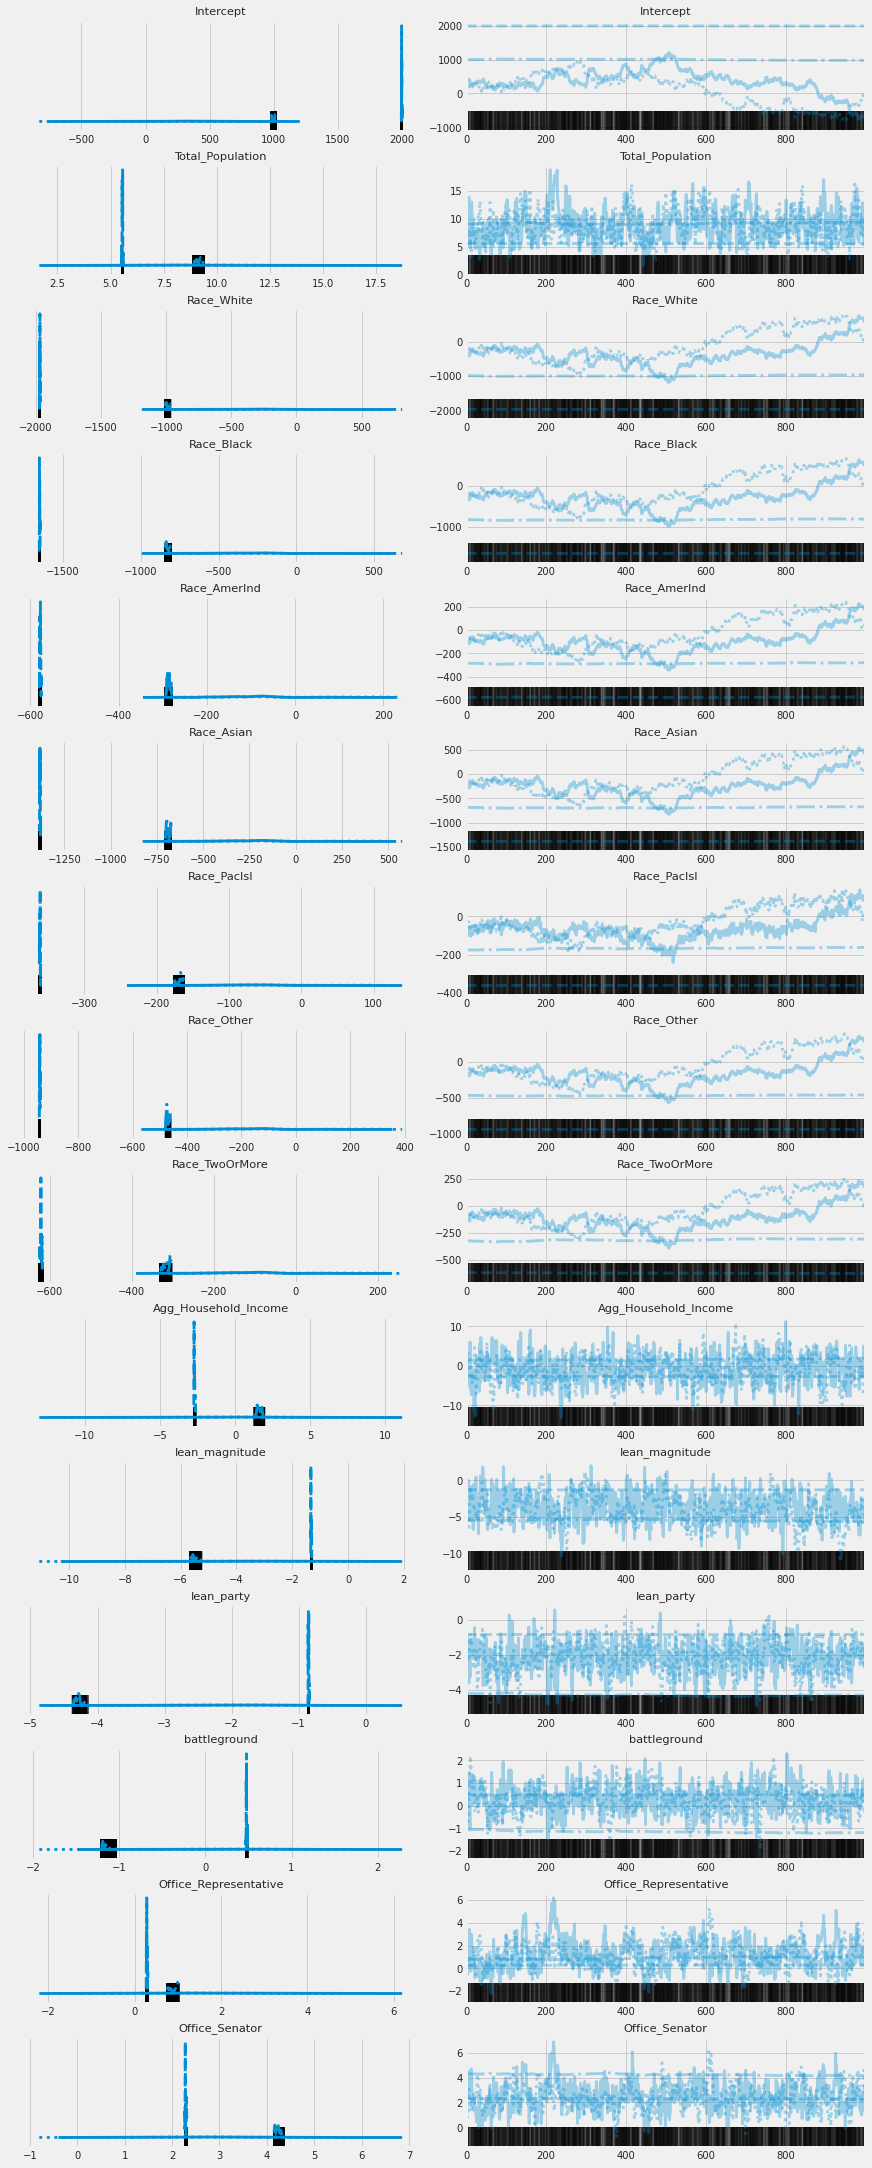

In [90]:
test_trace = pickle.load(open('biden_trace.pkl', 'rb'))
az.plot_trace(test_trace);

test_trace = pickle.load(open('our_rev_trace.pkl', 'rb'))
az.plot_trace(test_trace);

test_trace = pickle.load(open('trump_trace.pkl', 'rb'))
az.plot_trace(test_trace);

test_trace = pickle.load(open('tea_party_trace.pkl', 'rb'))
az.plot_trace(test_trace);

In [91]:
est_trace = pickle.load(open('trump_trace.pkl', 'rb'))
print(pm.summary(test_trace)[["mean", "sd", "hdi_3%", "hdi_97%"]].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     mean &       sd &    hdi\_3\% &   hdi\_97\% \\
\midrule
Intercept             &  861.305 &  788.775 &  -445.912 &  2000.332 \\
Total\_Population      &    8.108 &    2.388 &     4.916 &    13.073 \\
Race\_White            & -852.619 &  777.379 & -1975.387 &   437.530 \\
Race\_Black            & -713.217 &  651.313 & -1653.098 &   367.250 \\
Race\_AmerInd          & -247.247 &  229.331 &  -579.924 &   134.067 \\
Race\_Asian            & -594.062 &  546.703 & -1385.163 &   315.213 \\
Race\_PacIsl           & -154.921 &  138.795 &  -362.466 &    63.556 \\
Race\_Other            & -406.365 &  371.355 &  -943.395 &   211.289 \\
Race\_TwoOrMore        & -271.936 &  243.581 &  -625.405 &   136.024 \\
Agg\_Household\_Income  &   -0.760 &    2.941 &    -6.476 &     4.551 \\
lean\_magnitude        &   -3.614 &    2.034 &    -6.742 &    -0.752 \\
lean\_party            &   -2.363 &    1.366 &    -4.341 &    -0.840 \\
battleground          &   -0.033 &    0

In [92]:
test_trace = pickle.load(open('our_rev_trace.pkl', 'rb'))
print(pm.summary(test_trace)[["mean", "sd", "hdi_3%", "hdi_97%"]].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     mean &       sd &   hdi\_3\% &  hdi\_97\% \\
\midrule
Intercept             & -173.542 &  518.554 & -934.210 &  753.382 \\
Total\_Population      &    6.553 &    2.827 &    1.352 &   11.730 \\
Race\_White            &  172.120 &  511.281 & -741.604 &  922.001 \\
Race\_Black            &  143.821 &  428.132 & -618.570 &  774.622 \\
Race\_AmerInd          &   49.657 &  150.318 & -217.719 &  270.038 \\
Race\_Asian            &  122.535 &  359.224 & -520.013 &  646.593 \\
Race\_PacIsl           &   18.774 &   83.855 & -132.593 &  140.807 \\
Race\_Other            &   83.245 &  244.088 & -350.221 &  445.520 \\
Race\_TwoOrMore        &   56.154 &  162.436 & -236.947 &  292.235 \\
Agg\_Household\_Income  &   -1.412 &    1.670 &   -4.695 &    1.719 \\
lean\_magnitude        &   -2.550 &    0.873 &   -4.089 &   -0.732 \\
lean\_party            &   -1.353 &    0.341 &   -1.945 &   -0.677 \\
battleground          &   -0.187 &    0.327 &   -0.862 &    0.351

In [93]:
test_trace = pickle.load(open('our_rev_trace.pkl', 'rb'))
print(pm.summary(test_trace)[["mean", "sd", "hdi_3%", "hdi_97%"]].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     mean &       sd &   hdi\_3\% &  hdi\_97\% \\
\midrule
Intercept             & -173.542 &  518.554 & -934.210 &  753.382 \\
Total\_Population      &    6.553 &    2.827 &    1.352 &   11.730 \\
Race\_White            &  172.120 &  511.281 & -741.604 &  922.001 \\
Race\_Black            &  143.821 &  428.132 & -618.570 &  774.622 \\
Race\_AmerInd          &   49.657 &  150.318 & -217.719 &  270.038 \\
Race\_Asian            &  122.535 &  359.224 & -520.013 &  646.593 \\
Race\_PacIsl           &   18.774 &   83.855 & -132.593 &  140.807 \\
Race\_Other            &   83.245 &  244.088 & -350.221 &  445.520 \\
Race\_TwoOrMore        &   56.154 &  162.436 & -236.947 &  292.235 \\
Agg\_Household\_Income  &   -1.412 &    1.670 &   -4.695 &    1.719 \\
lean\_magnitude        &   -2.550 &    0.873 &   -4.089 &   -0.732 \\
lean\_party            &   -1.353 &    0.341 &   -1.945 &   -0.677 \\
battleground          &   -0.187 &    0.327 &   -0.862 &    0.351

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1aad3675-d883-4a2d-8229-41e4e0cfc0c9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>